In [1]:
# Clean End-to-End Pipeline: Data Augmentation Study
## Simple CNN with TensorFlow Light Augmentation + Mixup

# This notebook provides a clean, simplified pipeline for testing data augmentation strategies on histology images.

In [2]:
# !pip install -U "numpy>=1.22,<1.24" "ml_dtypes==0.1.0"
!pip install -U "albumentationsx" "tensorflow[and-cuda]==2.15.*" "opencv-python" "scikit-image" 


  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.


## Import 

In [3]:
# 📦 IMPORTS AND SETUP
import os
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Any

import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
# IMAGE_SIZE = (64, 64)
# EPOCHS = 10
# LEARNING_RATE = 1e-3

print("✅ Setup complete!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-09-02 13:23:58.932503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 13:23:58.978872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 13:23:58.978902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registere

✅ Setup complete!
TensorFlow version: 2.15.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-09-02 13:24:00.699246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 13:24:00.746820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 13:24:00.747879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# 📁 DATA SETUP
working_dir = Path.cwd()
data_dir = working_dir / "COSC2779-DATA"
data_zip = data_dir / "data.zip"

# Extract data if needed
if data_zip.exists() and not (data_dir / "Hematoxylin").exists():
    print("📦 Extracting data...")
    with zipfile.ZipFile(data_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    
    # Extract images if needed
    images_zip = data_dir / "Images.zip"
    if images_zip.exists():
        with zipfile.ZipFile(images_zip, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

IMAGE_DIR = data_dir / "Hematoxylin"
print(f"📂 Data directory: {data_dir}")
print(f"🖼️ Image directory: {IMAGE_DIR}")
print(f"📊 Image directory exists: {IMAGE_DIR.exists()}")

📂 Data directory: /home/ec2-user/SageMaker/Asm1/COSC2779-DATA
🖼️ Image directory: /home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin
📊 Image directory exists: True


In [5]:
import os
import pandas as pd
def load_csvs_to_dict(directory):
    csv_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            csv_dict[filename] = df
    return csv_dict


In [6]:
csv_dict = load_csvs_to_dict(data_dir)


# EDA

In [7]:
# Inspect the csv dict
for key, value in csv_dict.items():
    print(key)
    print(value.columns)
    print("-" * 100)

s1234567_predictions.csv
Index(['imageID', 'label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole'], dtype='object')
----------------------------------------------------------------------------------------------------
future_data_2025.csv
Index(['imageID'], dtype='object')
----------------------------------------------------------------------------------------------------
dev_data_2025.csv
Index(['imageID', 'label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole'], dtype='object')
----------------------------------------------------------------------------------------------------


In [8]:
dev_data = csv_dict["dev_data_2025.csv"]
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [9]:
#Sample of the data
dev_data.head()

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,Lymphocyte,round,unsegmented-round,no
1,Img_00002,Monocyte,irregular,unsegmented-indented,no
2,Img_00003,Monocyte,irregular,irregular,yes
3,Img_00004,Basophil,round,segmented-multilobed,no
4,Img_00005,Neutrophil,round,unsegmented-band,no


In [10]:
dev_data.tail()

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no
4996,Img_04997,Neutrophil,round,unsegmented-band,no
4997,Img_04998,Basophil,round,irregular,no
4998,Img_04999,Neutrophil,round,unsegmented-band,no
4999,Img_05000,Neutrophil,round,unsegmented-band,no


In [11]:
dev_data = dev_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Strip whitespace + lowercase everything except imageID
for col in dev_data.columns:
    if col != "imageID":
        dev_data[col] = dev_data[col].astype(str).str.strip().str.lower()


/tmp/ipykernel_1327/3395043242.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dev_data = dev_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [12]:
# Get all of the unique values in the "label" column
print(dev_data["label"].unique())

['lymphocyte' 'monocyte' 'basophil' 'neutrophil' 'eosinophil']


In [13]:
import plotly.express as px

def plot_column_distribution_pie(df, column, title=None):
    """
    Plots an interactive pie chart showing the distribution of values in any given column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to visualize.
        title (str, optional): Custom title for the chart. If None, a default will be used.

    Returns:
        plotly.graph_objs._figure.Figure: The Plotly pie chart figure.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Count unique values
    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = [column.capitalize(), 'Count']

    # Default title
    if title is None:
        title = f"Distribution of '{column}'"

    # Create the pie chart
    fig = px.pie(
        value_counts,
        names=column.capitalize(),
        values='Count',
        title=title,
        color_discrete_sequence=px.colors.qualitative.Set3
    )
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(showlegend=True)
    fig.show()



In [14]:
# plot_column_distribution_pie(dev_data, "label")

In [15]:
# Get all of the unique values in the "label" column
print(dev_data["cell_shape"].unique())

['round' 'irregular']


In [16]:
# plot_column_distribution_pie(dev_data, "cell_shape")

In [17]:
print(dev_data["nucleus_shape"].unique())
plot_column_distribution_pie(dev_data, "nucleus_shape")

['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']


In [18]:
print(dev_data["cytoplasm_vacuole"].unique())
plot_column_distribution_pie(dev_data, "cytoplasm_vacuole")

['no' 'yes']


In [19]:
dev_data.drop_duplicates(inplace=True)
dev_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [20]:
import os
import hashlib
from PIL import Image
import matplotlib.pyplot as plt

def find_and_show_duplicate_images(directory):
    """
    Scans the given directory for duplicate images by comparing their hashes.
    If duplicates are found, displays them side by side.
    """
    hash_dict = {}
    duplicates = []

    for root, _, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in hash_dict:
                    duplicates.append((file_path, hash_dict[file_hash]))
                else:
                    hash_dict[file_hash] = file_path
            except Exception as e:
                print(f"Could not process {file_path}: {e}")

    if duplicates:
        print(f"Found {len(duplicates)} duplicate pairs. Visualizing them:")
        for dup, orig in duplicates:
            try:
                img1 = Image.open(orig)
                img2 = Image.open(dup)
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                axes[0].imshow(img1)
                axes[0].set_title(f'Original:\n{os.path.basename(orig)}')
                axes[0].axis('off')
                axes[1].imshow(img2)
                axes[1].set_title(f'Duplicate:\n{os.path.basename(dup)}')
                axes[1].axis('off')
                plt.show()
            except Exception as e:
                print(f"Could not display images {orig} and {dup}: {e}")
    else:
        print("No duplicate images found.")
    return duplicates

In [21]:
# duplicates = find_and_show_duplicate_images(data_dir/"Hematoxylin")


In [22]:
import os
import hashlib

def extract_duplicate_images(directory):
    """
    Scans the given directory for duplicate images by comparing their hashes.
    Returns a list of tuples: (original_image_path, [duplicate_image_path1, duplicate_image_path2, ...])
    """
    hash_dict = {}
    duplicates_dict = {}

    for root, _, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in hash_dict:
                    orig = hash_dict[file_hash]
                    if orig not in duplicates_dict:
                        duplicates_dict[orig] = []
                    duplicates_dict[orig].append(file_path)
                else:
                    hash_dict[file_hash] = file_path
            except Exception as e:
                print(f"Could not process {file_path}: {e}")

    # Convert to list of (original, [duplicates...])
    duplicates_list = [(orig, dups) for orig, dups in duplicates_dict.items()]
    return duplicates_list

In [23]:
duplicates = extract_duplicate_images(data_dir/"Hematoxylin")

In [24]:
print(duplicates)

[('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_04876.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_07922.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_04024.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_06251.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_05308.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_06143.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_05183.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_07889.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_08209.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_03182.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_01143.jpg', ['/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_07204.jpg']), ('/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_01848.jpg', ['/home/ec2-user/SageMake

In [25]:
# Check image size
from PIL import Image

# Example: Check image sizes for all images in the Hematoxylin directory
image_sizes = {}
for root, _, files in os.walk(data_dir/"Hematoxylin"):
    for filename in files:
        file_path = os.path.join(root, filename)
        try:
            with Image.open(file_path) as img:
                image_sizes[file_path] = img.size  # (width, height)
        except Exception as e:
            print(f"Could not open {file_path}: {e}")

# Print out the image sizes (show a few as example)
for i, (path, size) in enumerate(image_sizes.items()):
    print(f"{path}: {size}")
    if i >= 9:
        break


/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_06432.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_05025.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_02943.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_01185.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_09451.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_03943.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_00281.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_05457.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_03103.jpg: (360, 363)
/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_00373.jpg: (366, 369)


In [26]:
dev_data['imageID']

0       Img_00001
1       Img_00002
2       Img_00003
3       Img_00004
4       Img_00005
          ...    
4995    Img_04996
4996    Img_04997
4997    Img_04998
4998    Img_04999
4999    Img_05000
Name: imageID, Length: 5000, dtype: object

In [27]:
import os

def extract_image_id(file_path):
    """Extracts the image ID (e.g., Img_07970) from a file path."""
    return os.path.splitext(os.path.basename(file_path))[0]

# Loop through each (original, [duplicates...]) pair
for orig, dups in duplicates:
    orig_id = extract_image_id(orig)
    # Print the original entry
    orig_row = dev_data[dev_data['imageID'] == orig_id]
    print(f"Original ({orig_id}):")
    print(orig_row)
    # Print each duplicate entry
    for dup in dups:
        dup_id = extract_image_id(dup)
        dup_row = dev_data[dev_data['imageID'] == dup_id]
        print(f"  Duplicate ({dup_id}):")
        print(dup_row)
    print("-" * 40)

Original (Img_04876):
        imageID     label cell_shape nucleus_shape cytoplasm_vacuole
4875  Img_04876  basophil      round     irregular                no
  Duplicate (Img_07922):
Empty DataFrame
Columns: [imageID, label, cell_shape, nucleus_shape, cytoplasm_vacuole]
Index: []
----------------------------------------
Original (Img_04024):
        imageID       label cell_shape     nucleus_shape cytoplasm_vacuole
4023  Img_04024  eosinophil      round  unsegmented-band                no
  Duplicate (Img_06251):
Empty DataFrame
Columns: [imageID, label, cell_shape, nucleus_shape, cytoplasm_vacuole]
Index: []
----------------------------------------
Original (Img_05308):
Empty DataFrame
Columns: [imageID, label, cell_shape, nucleus_shape, cytoplasm_vacuole]
Index: []
  Duplicate (Img_06143):
Empty DataFrame
Columns: [imageID, label, cell_shape, nucleus_shape, cytoplasm_vacuole]
Index: []
----------------------------------------
Original (Img_05183):
Empty DataFrame
Columns: [imageID,

In [28]:
dev_data = csv_dict["dev_data_2025.csv"]
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [29]:
import os

def extract_image_id(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Build a set of all duplicate image IDs (not originals)
duplicate_ids = set()
for orig, dups in duplicates:
    for dup in dups:
        duplicate_ids.add(extract_image_id(dup))

# Remove rows whose imageID is in the duplicate_ids set
dev_data_no_duplicates = dev_data[~dev_data['imageID'].isin(duplicate_ids)].reset_index(drop=True)

print(dev_data_no_duplicates)

        imageID       label cell_shape         nucleus_shape cytoplasm_vacuole
0     Img_00001  Lymphocyte      round     unsegmented-round                no
1     Img_00002    Monocyte  irregular  unsegmented-indented                no
2     Img_00003    Monocyte  irregular             irregular               yes
3     Img_00004    Basophil      round  segmented-multilobed                no
4     Img_00005  Neutrophil      round      unsegmented-band                no
...         ...         ...        ...                   ...               ...
4992  Img_04996  Lymphocyte  irregular     unsegmented-round                no
4993  Img_04997  Neutrophil      round      unsegmented-band                no
4994  Img_04998    Basophil      round             irregular                no
4995  Img_04999  Neutrophil      round      unsegmented-band                no
4996  Img_05000  Neutrophil      round      unsegmented-band                no

[4997 rows x 5 columns]


In [30]:
# 🔬 DATA AUGMENTATION STUDY WITH MIXUP
# This section implements a comprehensive data augmentation strategy study
# comparing baseline performance vs augmented data with mixup for multitask learning

import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import cv2
from typing import Dict, List, Tuple
import random

print("🧪 Starting Data Augmentation Study with Mixup...")

# Use the cleaned dataset
df = dev_data_no_duplicates.copy()
print(f"📊 Dataset size: {len(df)} samples")

# Display class distributions
print("\n📈 Class Distributions:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {df[col].value_counts().to_dict()}")


🧪 Starting Data Augmentation Study with Mixup...
📊 Dataset size: 4997 samples

📈 Class Distributions:
label: {'Neutrophil': 1610, 'Eosinophil': 1503, 'Monocyte': 679, 'Basophil': 626, 'Lymphocyte': 579}
cell_shape: {'round': 3901, 'irregular': 1096}
nucleus_shape: {'segmented-bilobed': 1489, 'unsegmented-band': 1290, 'unsegmented-indented': 648, 'segmented-multilobed': 626, 'unsegmented-round': 516, 'irregular': 428}
cytoplasm_vacuole: {'no': 4636, 'yes': 361}


In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Apply Label Encoding
le_cell_shape = LabelEncoder()
le_nucleus_shape = LabelEncoder()
le_cytoplasm_vacuole = LabelEncoder()
le_label = LabelEncoder()

dev_data_no_duplicates["label_idx"] = le_label.fit_transform(dev_data_no_duplicates["label"])
dev_data_no_duplicates["cell_shape_idx"] = le_cell_shape.fit_transform(dev_data_no_duplicates["cell_shape"])
dev_data_no_duplicates["nucleus_shape_idx"] = le_nucleus_shape.fit_transform(dev_data_no_duplicates["nucleus_shape"])
dev_data_no_duplicates["cytoplasm_vacuole_idx"] = le_cytoplasm_vacuole.fit_transform(dev_data_no_duplicates["cytoplasm_vacuole"])


In [32]:
import pandas as pd
import numpy as np

TARGET_COLS = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]

# -------- 1) Fit class maps on TRAIN ONLY --------
def fit_class_maps(train_df: pd.DataFrame, cols=TARGET_COLS, sort_classes=True, add_unk=False):
    """
    Returns:
      class_maps: {col: {class_value: index}}
      num_classes: {col: K}
    """
    class_maps = {}
    for col in cols:
        classes = train_df[col].dropna().unique().tolist()
        if sort_classes:
            classes = sorted(classes)
        cmap = {cls: i for i, cls in enumerate(classes)}
        if add_unk:
            cmap["__UNK__"] = len(cmap)
        class_maps[col] = cmap
    num_classes = {col: len(cm) for col, cm in class_maps.items()}
    return class_maps, num_classes

# -------- 2) Append OHE columns to ANY split --------
def append_ohe(
    df: pd.DataFrame,
    class_maps: dict,
    prefix_sep: str = "__",
    drop_original: bool = False,
    dtype: str = "float32",
    unknown_policy: str = "error",  # "error" or "use_unk" (requires "__UNK__" in class_maps)
) -> pd.DataFrame:
    """
    Appends one-hot columns for each target col to the provided df and returns a new df.
    Column names look like: label__<class>, cell_shape__<class>, ...
    """
    out = df.copy()
    for col, cmap in class_maps.items():
        # handle unseen values
        s = out[col]
        if unknown_policy == "error":
            unseen = set(s.dropna().unique()) - set(cmap.keys())
            if unseen:
                raise ValueError(
                    f"Unseen labels in '{col}': {sorted(unseen)}. "
                    "Use unknown_policy='use_unk' and include '__UNK__' in class_maps if desired."
                )
            idx = s.map(cmap).astype("Int64")  # nullable int
        elif unknown_policy == "use_unk":
            if "__UNK__" not in cmap:
                raise ValueError(f"unknown_policy='use_unk' requires '__UNK__' in class map for '{col}'.")
            idx = s.map(cmap).fillna(cmap["__UNK__"]).astype(int)
        else:
            raise ValueError("unknown_policy must be 'error' or 'use_unk'.")

        K = len(cmap)
        # Make one-hot matrix
        arr = np.zeros((len(out), K), dtype=dtype)
        valid_mask = idx.notna()
        arr[valid_mask.to_numpy(), idx[valid_mask].to_numpy()] = 1.0

        # Build column names in the order of cmap keys
        ordered_classes = list(cmap.keys())
        ohe_cols = [f"{col}{prefix_sep}{cls}" for cls in ordered_classes]
        ohe_df = pd.DataFrame(arr, columns=ohe_cols, index=out.index)
        out = pd.concat([out, ohe_df], axis=1)

        if drop_original:
            out = out.drop(columns=[col])

    return out


In [33]:
# Fit on train
class_maps, NUM_CLASSES = fit_class_maps(dev_data_no_duplicates, add_unk=False)

# Append OHE to each split
df_ohe = append_ohe(dev_data_no_duplicates, class_maps, drop_original=False, unknown_policy="error")


In [34]:
df_ohe

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,label_idx,cell_shape_idx,nucleus_shape_idx,cytoplasm_vacuole_idx,label__Basophil,...,cell_shape__irregular,cell_shape__round,nucleus_shape__irregular,nucleus_shape__segmented-bilobed,nucleus_shape__segmented-multilobed,nucleus_shape__unsegmented-band,nucleus_shape__unsegmented-indented,nucleus_shape__unsegmented-round,cytoplasm_vacuole__no,cytoplasm_vacuole__yes
0,Img_00001,Lymphocyte,round,unsegmented-round,no,2,1,5,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,Img_00002,Monocyte,irregular,unsegmented-indented,no,3,0,4,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Img_00003,Monocyte,irregular,irregular,yes,3,0,0,1,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Img_00004,Basophil,round,segmented-multilobed,no,0,1,2,0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,Img_00005,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,Img_04996,Lymphocyte,irregular,unsegmented-round,no,2,0,5,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4993,Img_04997,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4994,Img_04998,Basophil,round,irregular,no,0,1,0,0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4995,Img_04999,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [35]:
def show_crosstab(index_col, column_col, title_prefix, df):
    ct_counts = pd.crosstab(df[index_col], df[column_col]).sort_index()
    ct_props = pd.crosstab(df[index_col], df[column_col], normalize='index').round(3).sort_index()
    print(f"{title_prefix} — Counts", ct_counts)
    print(f"{title_prefix} — Row Proportions", ct_props)
    return ct_counts, ct_props

In [36]:
# Label x Vacuole
lv_counts, lv_props = show_crosstab('label', 'cytoplasm_vacuole', 'Label × Vacuole', dev_data_no_duplicates)


Label × Vacuole — Counts cytoplasm_vacuole    no  yes
label                       
Basophil            624    2
Eosinophil         1498    5
Lymphocyte          579    0
Monocyte            379  300
Neutrophil         1556   54
Label × Vacuole — Row Proportions cytoplasm_vacuole     no    yes
label                          
Basophil           0.997  0.003
Eosinophil         0.997  0.003
Lymphocyte         1.000  0.000
Monocyte           0.558  0.442
Neutrophil         0.966  0.034


In [37]:
# Label x Cell Shape
lc_counts, lc_props = show_crosstab('label', 'cell_shape', 'Label × Cell Shape',dev_data_no_duplicates)

Label × Cell Shape — Counts cell_shape  irregular  round
label                       
Basophil           72    554
Eosinophil        125   1378
Lymphocyte        186    393
Monocyte          366    313
Neutrophil        347   1263
Label × Cell Shape — Row Proportions cell_shape  irregular  round
label                       
Basophil        0.115  0.885
Eosinophil      0.083  0.917
Lymphocyte      0.321  0.679
Monocyte        0.539  0.461
Neutrophil      0.216  0.784


In [38]:
# Label x Nucleus Shape
ln_counts, ln_props = show_crosstab('label', 'nucleus_shape', 'Label × Nucleus Shape', dev_data_no_duplicates)


Label × Nucleus Shape — Counts nucleus_shape  irregular  segmented-bilobed  segmented-multilobed  \
label                                                               
Basophil             266                169                   128   
Eosinophil            11               1027                   296   
Lymphocyte            17                  0                     0   
Monocyte             121                  1                     0   
Neutrophil            13                292                   202   

nucleus_shape  unsegmented-band  unsegmented-indented  unsegmented-round  
label                                                                     
Basophil                     37                    10                 16  
Eosinophil                  153                     9                  7  
Lymphocyte                    0                   110                452  
Monocyte                      0                   517                 40  
Neutrophil                 1100    

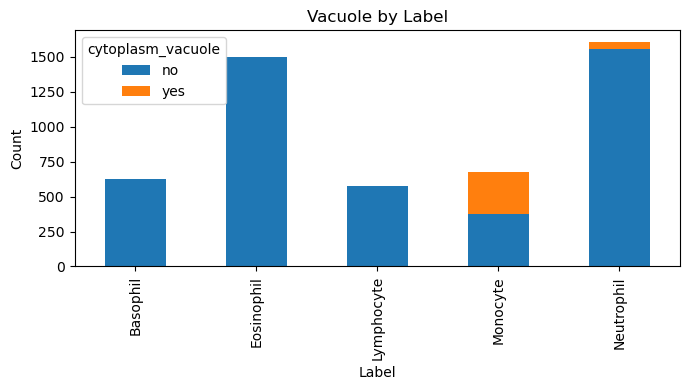

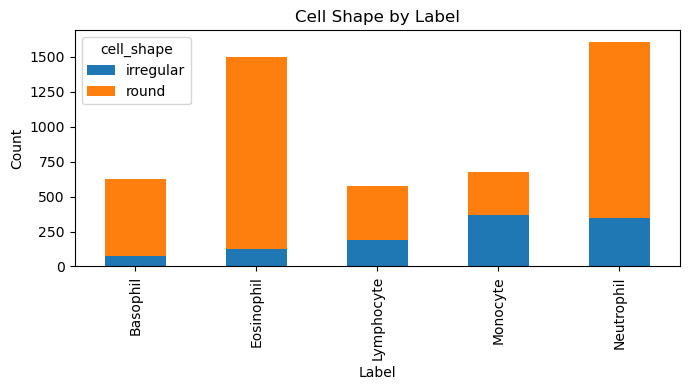

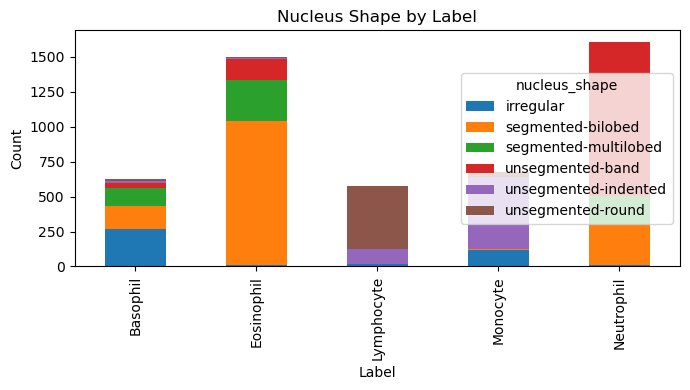

In [39]:

def stacked_bar(counts_df, title, xlabel=''):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111)
    counts_df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

stacked_bar(lv_counts, 'Vacuole by Label', 'Label')
stacked_bar(lc_counts, 'Cell Shape by Label', 'Label')
stacked_bar(ln_counts, 'Nucleus Shape by Label', 'Label')

In [40]:
def heatmap(props_df, title):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111)
    im = ax.imshow(props_df.values, aspect='auto')
    ax.set_xticks(np.arange(props_df.shape[1]))
    ax.set_yticks(np.arange(props_df.shape[0]))
    ax.set_xticklabels(list(props_df.columns))
    ax.set_yticklabels(list(props_df.index))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Proportion', rotation=90, va="bottom")
    plt.tight_layout()
    plt.show()


In [41]:

# heatmap(lc_props, 'Proportion Heatmap: Cell Shape within Label')
# heatmap(ln_props, 'Proportion Heatmap: Nucleus Shape within Label')
# heatmap(lv_props, 'Proportion Heatmap: Vacuole within Label')

In [42]:
def heatmap_from_df(mat: pd.DataFrame, title: str, fname: str):
    fig = plt.figure(figsize=(8,4.8))
    ax = fig.add_subplot(111)
    im = ax.imshow(mat.values, aspect="auto")
    ax.set_xticks(range(mat.shape[1]))
    ax.set_yticks(range(mat.shape[0]))
    ax.set_xticklabels(list(mat.columns), rotation=45, ha="right")
    ax.set_yticklabels(list(mat.index))
    ax.set_title(title)
    # annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    

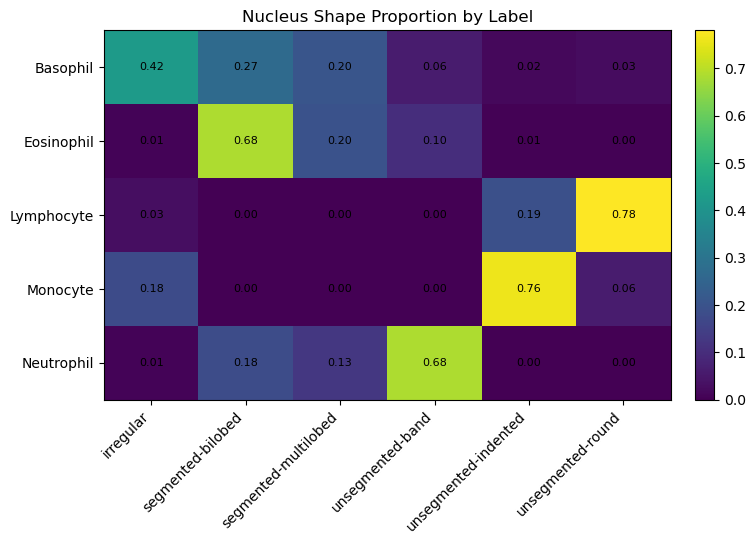

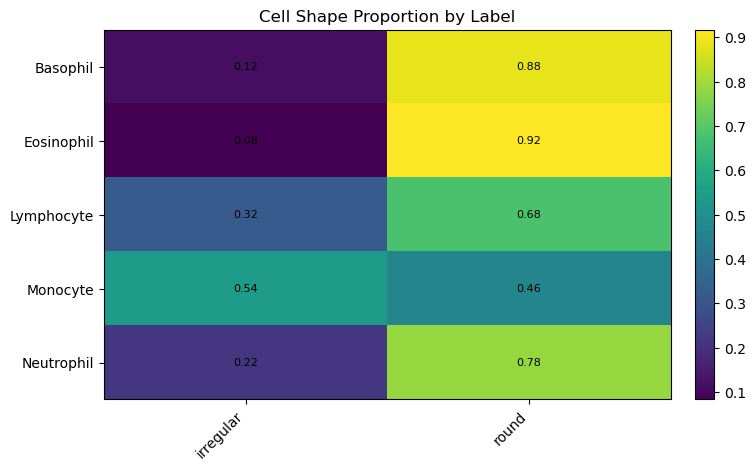

In [43]:
#TODO: Review the following label make it white
# 3.5 Heatmap of nucleus_shape proportions per label
nuc_prop = pd.crosstab(dev_data_no_duplicates["label"], dev_data_no_duplicates["nucleus_shape"], normalize="index").sort_index()
p4 = heatmap_from_df(nuc_prop, "Nucleus Shape Proportion by Label", "eda_heatmap_nucleus_shape_by_label.png")

# 3.6 Heatmap of cell_shape proportions per label
cell_prop = pd.crosstab(dev_data_no_duplicates["label"], dev_data_no_duplicates["cell_shape"], normalize="index").sort_index()
p5 = heatmap_from_df(cell_prop, "Cell Shape Proportion by Label", "eda_heatmap_cell_shape_by_label.png")

# 3.7 Top 15 phenotypes: label × vacuole × nucleus_shape (counts)
tri = (
    dev_data_no_duplicates.groupby(["label", "cytoplasm_vacuole", "nucleus_shape"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
      .head(15)
)

In [44]:
tri = (
    dev_data_no_duplicates.groupby(["label", "cytoplasm_vacuole", "nucleus_shape"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
      .head(15)
)


Text(0.5, 1.0, 'Top 15 Phenotype Combinations')

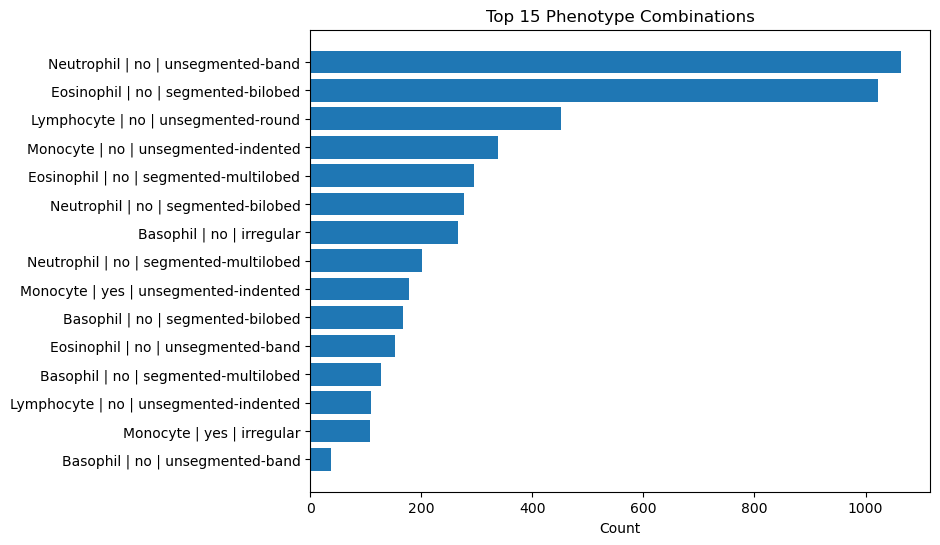

In [45]:
fig6 = plt.figure(figsize=(8,6))
ax6 = fig6.add_subplot(111)
ax6.barh(
    np.arange(len(tri)),
    tri["count"].values
)
ax6.set_yticks(np.arange(len(tri)))
ax6.set_yticklabels(
    [f"{r.label} | {r.cytoplasm_vacuole} | {r.nucleus_shape}" for r in tri.itertuples(index=False)],
)
ax6.invert_yaxis()
ax6.set_xlabel("Count")
ax6.set_title("Top 15 Phenotype Combinations")

Top phenotype = Neutrophil | no vacuole | unsegmented-band (~1,050 samples).
→ Suggests this is the most common morphological presentation in your data.

Second most common = Eosinophil | no vacuole | segmented-bilobed (~1,000 samples).
→ Consistent with typical eosinophil morphology.

Vacuole presence is rare in the top list — only Monocyte | yes | unsegmented-indented and Monocyte | yes | irregular appear.
→ Fits biology: vacuoles are more common in monocytes and sometimes activated neutrophils.

Lymphocytes in the top 15 are mostly “no vacuole” and unsegmented-round or unsegmented-indented nuclei.

Basophils occur with multiple nucleus shapes (irregular, segmented-bilobed, segmented-multilobed), but rarely have vacuoles.



In [46]:
# # 3.8 Scatter-matrix of index features colored by label (default colors from pandas/mpl)
# from pandas.plotting import scatter_matrix
# fig7 = plt.figure(figsize=(7,7))
# axs = scatter_matrix(
#     dev_data_no_duplicates[["cell_shape_idx", "nucleus_shape_idx", "cytoplasm_vacuole_idx"]].astype(float),
#     figsize=(7,7),
#     diagonal='hist'
# )
# plt.suptitle("Scatter Matrix of Encoded Morphology Features", y=0.92)

## Conduct statistical testing

In [47]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi2_test_and_interpret(df, col1, col2, alpha=0.05):
    contingency = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\n{col1} vs {col2}")
    print(f"Chi2: {chi2:.4f}, p-value: {p:.4g}, dof: {dof}")
    if p < alpha:
        print(f"Result: Statistically significant association (p < {alpha})")
    else:
        print(f"Result: No statistically significant association (p >= {alpha})")

# Example usage:
chi2_test_and_interpret(dev_data_no_duplicates, 'cell_shape_idx', 'nucleus_shape_idx')
chi2_test_and_interpret(dev_data_no_duplicates, 'cell_shape_idx', 'cytoplasm_vacuole_idx')
chi2_test_and_interpret(dev_data_no_duplicates, 'nucleus_shape_idx', 'cytoplasm_vacuole_idx')


cell_shape_idx vs nucleus_shape_idx
Chi2: 353.5787, p-value: 2.969e-74, dof: 5
Result: Statistically significant association (p < 0.05)

cell_shape_idx vs cytoplasm_vacuole_idx
Chi2: 735.1211, p-value: 6.897e-162, dof: 1
Result: Statistically significant association (p < 0.05)

nucleus_shape_idx vs cytoplasm_vacuole_idx
Chi2: 773.5686, p-value: 6.039e-165, dof: 5
Result: Statistically significant association (p < 0.05)


### 📌 Interpretation
These variables are not independent:

Knowing one label gives you strong predictive clues about the others.

Especially strong between nucleus_shape_idx and cytoplasm_vacuole_idx.



In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path
from collections import defaultdict

def plot_color_distribution_single_vs_aggregate(dev_data, images_dir, label_column='label'):
    """
    For each category:
    - Display one random image.
    - Compute mean ± std color histograms of the remaining images.
    
    Parameters:
    - dev_data: DataFrame with image IDs and labels
    - images_dir: Directory containing image files
    - label_column: Column with category labels
    """
    categories = dev_data[label_column].unique()
    category_images = defaultdict(list)
    
    for _, row in dev_data.iterrows():
        category_images[row[label_column]].append(row['imageID'])
    
    # Setup plot: 1 row = category, 3 cols: selected image, mean hist, mean ± std hist
    fig, axes = plt.subplots(len(categories), 3, figsize=(15, 4 * len(categories)))
    if len(categories) == 1:
        axes = axes.reshape(1, -1)

    colors = ['red', 'green', 'blue']
    channel_names = ['Red', 'Green', 'Blue']
    
    for i, category in enumerate(categories):
        image_ids = category_images[category]
        
        if not image_ids:
            continue

        # Randomly select one image
        selected_id = random.choice(image_ids)
        remaining_ids = [img_id for img_id in image_ids if img_id != selected_id]

        # --- Plot the selected image ---
        selected_path = Path(images_dir) / f"{selected_id}.jpg"
        if selected_path.exists():
            img = cv2.imread(str(selected_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title(f"{category} - Sample: {selected_id}")
            axes[i, 0].axis('off')
        else:
            axes[i, 0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i, 0].axis('off')

        # --- Process remaining images ---
        all_histograms = {0: [], 1: [], 2: []}  # BGR channels

        for img_id in remaining_ids:
            img_path = Path(images_dir) / f"{img_id}.jpg"
            if img_path.exists():
                img = cv2.imread(str(img_path))
                for k in range(3):  # B, G, R
                    hist = cv2.calcHist([img], [k], None, [256], [0, 256])
                    all_histograms[k].append(hist.flatten())

        ax_mean = axes[i, 1]
        ax_std = axes[i, 2]
        has_data = False

        for k, color in enumerate(colors):
            if all_histograms[k]:
                mean_hist = np.mean(all_histograms[k], axis=0)
                std_hist = np.std(all_histograms[k], axis=0)

                ax_mean.plot(mean_hist, color=color, label=f'{channel_names[k]} Mean')
                ax_std.plot(mean_hist, color=color, label=f'{channel_names[k]} Mean')
                ax_std.fill_between(range(256), mean_hist - std_hist, mean_hist + std_hist, color=color, alpha=0.3)

                has_data = True

        ax_mean.set_title(f'{category} - Mean Color Dist')
        ax_std.set_title(f'{category} - Mean ± Std Dev')
        for ax in [ax_mean, ax_std]:
            ax.set_xlabel('Pixel Intensity')
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
            if has_data:
                ax.legend()

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\nSummary:")
    for category in categories:
        total = len(category_images[category])
        print(f"{category}: {total} images (1 shown, {total-1} aggregated)")


In [49]:
# plot_color_distribution_single_vs_aggregate(dev_data_no_duplicates, data_dir / "Hematoxylin", 'label')

In [50]:
# plot_color_distribution_single_vs_aggregate(dev_data_no_duplicates, data_dir / "Hematoxylin", 'cytoplasm_vacuole')

## Try different color space

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path
from collections import defaultdict

# -----------------------------
# Color space configuration
# -----------------------------
COLOR_SPACES = {
    "HSV":   (cv2.COLOR_BGR2HSV,    ["Hue", "Saturation", "Value"],      ["orange", "blue", "gray"],
              [(0,180), (0,256), (0,256)]),   # Hue range in OpenCV: 0..179
    "Lab":   (cv2.COLOR_BGR2Lab,    ["L", "a", "b"],                     ["black", "green", "purple"],
              [(0,256), (0,256), (0,256)]),
}

def plot_color_distribution_all_spaces(
    dev_data,
    images_dir,
    groupby_cols=("label", "cytoplasm_vacuole"),
    color_spaces=COLOR_SPACES,
    bins=256,
    seed=0
):
    rng = random.Random(seed)

    # ---- Build groups ----
    groups = defaultdict(list)
    for _, row in dev_data.iterrows():
        key = tuple(row[c] for c in groupby_cols)
        groups[key].append(row["imageID"])

    group_keys = sorted(groups.keys())

    # ---- Iterate over color spaces ----
    for cs_name, (cv_code, ch_names, ch_colors, ch_ranges) in color_spaces.items():
        n_groups = len(group_keys)
        fig, axes = plt.subplots(n_groups, 3, figsize=(16, 4 * max(1, n_groups)))
        if n_groups == 1:
            axes = axes.reshape(1, -1)

        print(f"\n=== {cs_name} Color Space ===")

        for i, key in enumerate(group_keys):
            img_ids = groups[key]
            title_suffix = " | ".join(f"{c}={v}" for c, v in zip(groupby_cols, key))

            # Pick one sample to show
            sel_id = rng.choice(img_ids)
            rest_ids = [x for x in img_ids if x != sel_id]

            # 1) Show RGB image
            ax_img = axes[i, 0]
            p = Path(images_dir) / f"{sel_id}.jpg"
            if p.exists():
                bgr = cv2.imread(str(p))
                rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                ax_img.imshow(rgb)
                ax_img.set_title(f"{title_suffix}\nSample: {sel_id}")
                ax_img.axis('off')
            else:
                ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center")
                ax_img.axis('off')

            # 2) Aggregate histograms AND pixel-intensity stats
            per_ch_hists = {0: [], 1: [], 2: []}

            # pixel-level stats collectors (per image, per channel)
            pix_means = []
            pix_stds = []

            for img_id in rest_ids:
                q = Path(images_dir) / f"{img_id}.jpg"
                if not q.exists():
                    continue
                bgr = cv2.imread(str(q))
                space = bgr if cv_code is None else cv2.cvtColor(bgr, cv_code)

                # histogram accumulation
                for ch in range(3):
                    r0, r1 = ch_ranges[ch]
                    hist = cv2.calcHist([space], [ch], None, [bins], [r0, r1]).flatten()
                    per_ch_hists[ch].append(hist)

                # pixel intensity stats (mean/std per channel)
                pix_means.append([space[:, :, ch].mean() for ch in range(3)])
                pix_stds.append([space[:, :, ch].std() for ch in range(3)])

            ax_mean, ax_band = axes[i, 1], axes[i, 2]
            has_data = any(len(v) for v in per_ch_hists.values())

            if has_data:
                xs = np.arange(bins)
                print(f"\nGroup: {title_suffix}")

                # Plot hist mean ± std and print histogram-shape stats
                for ch, color in enumerate(ch_colors):
                    if per_ch_hists[ch]:
                        m = np.mean(per_ch_hists[ch], axis=0)
                        s = np.std(per_ch_hists[ch], axis=0)

                        ax_mean.plot(xs, m, color=color, label=f"{ch_names[ch]} Mean")
                        ax_band.plot(xs, m, color=color, label=f"{ch_names[ch]} Mean")
                        ax_band.fill_between(xs, m - s, m + s, alpha=0.3)

                        # Histogram-shape summary (mean of bin heights, std of bin heights)
                        print(f"  {ch_names[ch]}: mean(hist)={m.mean():.2f}, std(hist)={m.std():.2f}")

                # Pixel-intensity summary (actual channel means/stds in this color space)
                if pix_means:
                    mean_of_means = np.mean(pix_means, axis=0)
                    mean_of_stds  = np.mean(pix_stds,  axis=0)
                    print("  Pixel intensity stats:")
                    for ch, name in enumerate(ch_names):
                        print(f"    {name}: mean(pixel)={mean_of_means[ch]:.2f}, std(pixel)={mean_of_stds[ch]:.2f}")

            ax_mean.set_title(f"{cs_name} — Mean Dist")
            ax_band.set_title(f"{cs_name} — Mean ± Std")
            for ax in (ax_mean, ax_band):
                ax.set_xlabel("Bin")
                ax.set_ylabel("Frequency")
                ax.grid(True, alpha=0.3)
                if has_data:
                    ax.legend()

        plt.tight_layout()
        plt.show()

        print(f"\n[{cs_name}] Summary by group:")
        for key in group_keys:
            total = len(groups[key])
            print(f"  {dict(zip(groupby_cols, key))}: {total} images (1 shown, {max(0,total-1)} aggregated)")



 Across HSV, YCbCr, and Lab spaces, each leukocyte type shows distinct, biologically consistent color patterns. Lymphocytes have narrow purple hue peaks (dense nuclei), monocytes show broader hue/brightness from gray-blue cytoplasm and vacuoles, basophils exhibit high saturation & low brightness from coarse purple granules, neutrophils balance dark nuclei with pale cytoplasm, and eosinophils add orange/red hue and high saturation from coarse granules.

In [52]:
# plot_color_distribution_all_spaces(
#     dev_data=dev_data_no_duplicates,
#     images_dir= data_dir / "Hematoxylin",
#     groupby_cols=("label", "cytoplasm_vacuole"),  # grouping
#     color_spaces=COLOR_SPACES,
#     bins=256,
#     seed=42
# )

**Big picture**

* Across all groups, **overall brightness is high** (RGB means mostly 243–246; HSV Value ≈243–246; Lab L ≈233–241). Slides are bright; differences are **subtle but consistent** across cell types.
* **Histogram means** are \~511 for all channels — that’s expected (they’re the *average bin heights*, not pixel means). The **informative part is the pixel means/stds** printed under “Pixel intensity stats”.

**By label (RGB / Lab / YCrCb)**

* **Eosinophils** are among the **brightest**:

  * Example: *Eosinophil, unsegmented-round* → RGB ≈ **(247.8, 240.9, 241.8)**; Lab **L ≈ 242.9**; YCrCb **Y ≈ 240.1**.
  * Interpretation: strong eosinophilic (orange-red) granules → higher R and luminance.
* **Monocytes** trend **darker/greyer**:

  * Example: *Monocyte, irregular* → RGB ≈ **(242.9, 230.2, 231.8)**; Lab **L ≈ 233.7**; YCrCb **Y ≈ 231.9**.
  * Interpretation: abundant grey-blue cytoplasm → lower L/Y, lower G/B.
* **Neutrophils** sit **between eosinophils and monocytes**:

  * Example: *Neutrophil, unsegmented-band* → RGB ≈ **(245.9, 236.8, 238.0)**; Lab **L ≈ 239.4**; YCrCb **Y ≈ 238.2**.
* **Lymphocytes** are **bright** but less extreme than eosinophils:

  * Example: *Lymphocyte, unsegmented-round* → Lab **L ≈ 238.6**, Y ≈ **237.4**.

**Color-space specifics**

* **HSV**: Saturation is **low across the board** (≈10–17), so staining is dominated by **Value (brightness)** rather than vivid color. Hue centers around **\~60–70** (OpenCV scale 0–179), with some groups (e.g., *Neutrophil unsegmented-indented*) showing higher H (\~83), i.e., a slight tint shift.
* **Lab**: Good separability in **L** (brightness) and modest, stable **a** (\~130)/**b** (\~123) means. Eosinophils often have **higher L**; monocytes lower L.
* **YCrCb**: **Cr channel means are nearly constant** (\~127.8 with tiny std) across groups → weak discriminative power here. **Y** behaves similarly to Lab **L**.

**Within-label morphology**

* Changing **nucleus shape** within a label generally causes **small shifts** (often ≤2 intensity units) compared to the between-label differences.
* A consistent pattern: **“unsegmented-round”** variants tend to be **slightly brighter** (higher L/Y/RGB) for several labels.

**Vacuoles**

* Comparing **vacuole yes/no** within the same label & nucleus shape shows **minimal changes** in average pixel intensity (differences typically small)


In [54]:
# %% [code] imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- helpers ---------------------------------------------------------------
def normalize_except_imageID(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if c != "imageID":
            df[c] = df[c].astype(str).str.strip().str.lower()
    return df

def add_stratum_simple(df: pd.DataFrame,
                       primary_cols=("label","cell_shape","nucleus_shape","cytoplasm_vacuole"),
                       sep="|") -> pd.Series:
    # build a combined key; if a column is missing, fill with 'na'
    cols = [c for c in primary_cols if c in df.columns]
    tmp = df[cols].fillna("na").astype(str)
    return tmp.apply(lambda r: sep.join(r.values.tolist()), axis=1)

def collapse_rare_strata(df: pd.DataFrame, min_count=3) -> pd.DataFrame:
    df = df.copy()
    vc = df["stratum"].value_counts()
    rare = df["stratum"].isin(vc[vc < min_count].index)
    # fall back to coarse label if rare
    if "label" in df.columns:
        df.loc[rare, "stratum"] = df.loc[rare, "label"].astype(str)
    return df

def _safe_stratify_split(df, test_size, random_state, stratify_col_candidates):
    """
    Try stratifying using the first viable column in stratify_col_candidates.
    Fallback to unstratified if none are viable (e.g., a class has only 1 sample).
    """
    for col in stratify_col_candidates:
        if col in df.columns:
            vc = df[col].value_counts()
            if (vc >= 2).all() and vc.nunique() > 1:  # every class at least 2; >1 class
                return train_test_split(
                    df, test_size=test_size, random_state=random_state, stratify=df[col]
                )
    # fallback: no stratification
    return train_test_split(df, test_size=test_size, random_state=random_state, stratify=None)

def oversample_to_max_by_group(df: pd.DataFrame, group_col: str, random_state: int = 42) -> pd.DataFrame:
    """
    Randomly oversample rows so that every group in `group_col` reaches the size of the largest group.
    (Duplicate-with-replacement within each group.)
    """
    if group_col not in df.columns:
        raise KeyError(f"'{group_col}' not in dataframe.")
    rng = np.random.default_rng(random_state)
    parts = []
    max_n = df[group_col].value_counts().max()
    for _, g in df.groupby(group_col):
        n = len(g)
        if n < max_n:
            add = g.sample(n=max_n - n, replace=True, random_state=int(rng.integers(1e9)))
            parts.append(pd.concat([g, add], ignore_index=True))
        else:
            parts.append(g)
    return pd.concat(parts, ignore_index=True)

# --- main ------------------------------------------------------------------
def split_wbc_simple(df: pd.DataFrame,
                     train_size=0.70, val_size=0.15, test_size=0.15,
                     min_count=3,
                     random_state=42,
                     oversample_train=False,
                     oversample_by: str = "stratum"):  # "label" or "stratum"
    """
    Simple train/val/test split (no GSS).
    - Lowercases all non-imageID cols.
    - Builds 'stratum' from the 4 targets; collapses rare strata (< min_count) to 'label'.
    - Tries stratify on 'stratum' then 'label'.
    - Optionally oversample TRAIN ONLY by 'label' (default) or 'stratum'.
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "splits must sum to 1.0"

    d = normalize_except_imageID(df)

    # build & collapse strata
    d["stratum"] = add_stratum_simple(d)
    d = collapse_rare_strata(d, min_count=min_count)

    # train vs temp
    temp_size = val_size + test_size
    train_df, temp_df = _safe_stratify_split(
        d, test_size=temp_size, random_state=random_state,
        stratify_col_candidates=["stratum", "label"]
    )

    # val vs test (from temp)
    rel_val_size = val_size / (val_size + test_size)
    val_df, test_df = _safe_stratify_split(
        temp_df, test_size=1 - rel_val_size, random_state=random_state + 1,
        stratify_col_candidates=["stratum", "label"]
    )

    # optional oversampling on TRAIN ONLY
    if oversample_train:
        if oversample_by == "stratum":
            train_df = oversample_to_max_by_group(train_df, group_col="stratum", random_state=random_state)
        elif oversample_by == "label":
            train_df = oversample_to_max(train_df, by="label", random_state=random_state)
        else:
            raise ValueError("oversample_by must be 'label' or 'stratum'")

    # clean up helper col for outputs
    drop_cols = ["stratum"]
    return (train_df.drop(columns=drop_cols, errors="ignore").reset_index(drop=True),
            val_df.drop(columns=drop_cols, errors="ignore").reset_index(drop=True),
            test_df.drop(columns=drop_cols, errors="ignore").reset_index(drop=True))



In [55]:
train_df, val_df, test_df = split_wbc_simple(df_ohe, oversample_train=True)


In [56]:
df_ohe

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,label_idx,cell_shape_idx,nucleus_shape_idx,cytoplasm_vacuole_idx,label__Basophil,...,cell_shape__irregular,cell_shape__round,nucleus_shape__irregular,nucleus_shape__segmented-bilobed,nucleus_shape__segmented-multilobed,nucleus_shape__unsegmented-band,nucleus_shape__unsegmented-indented,nucleus_shape__unsegmented-round,cytoplasm_vacuole__no,cytoplasm_vacuole__yes
0,Img_00001,Lymphocyte,round,unsegmented-round,no,2,1,5,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,Img_00002,Monocyte,irregular,unsegmented-indented,no,3,0,4,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Img_00003,Monocyte,irregular,irregular,yes,3,0,0,1,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Img_00004,Basophil,round,segmented-multilobed,no,0,1,2,0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,Img_00005,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,Img_04996,Lymphocyte,irregular,unsegmented-round,no,2,0,5,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4993,Img_04997,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4994,Img_04998,Basophil,round,irregular,no,0,1,0,0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4995,Img_04999,Neutrophil,round,unsegmented-band,no,4,1,3,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [57]:
import matplotlib.pyplot as plt

def plot_category_counts(df, cols=None, figsize=(8,4)):
    """
    Plot category counts for given columns in a DataFrame.
    
    Args:
        df (pd.DataFrame): The dataframe (e.g., train_df).
        cols (list[str]): List of column names to plot. 
                          Defaults to ["label","cell_shape","nucleus_shape","cytoplasm_vacuole"].
        figsize (tuple): Figure size for each plot.
    """
    if cols is None:
        cols = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]

    for col in cols:
        if col not in df.columns:
            print(f"⚠️ Column {col} not found in dataframe, skipping.")
            continue
        counts = df[col].value_counts().sort_index()
        plt.figure(figsize=figsize)
        counts.plot(kind="bar")
        plt.title(f"Category Counts for {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


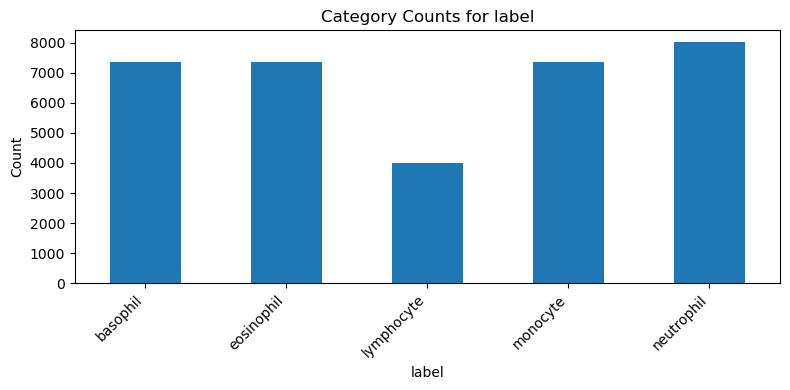

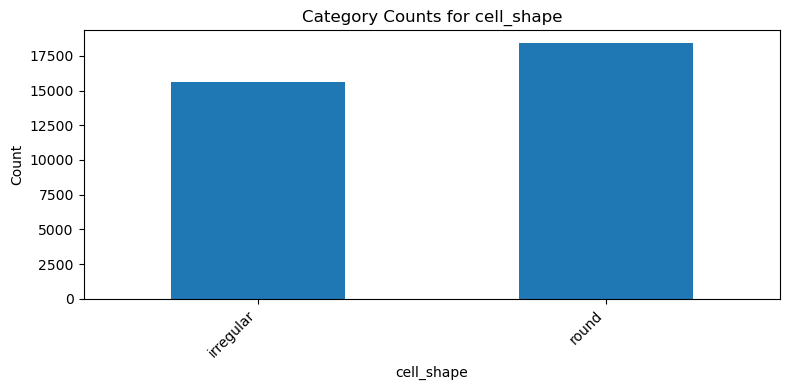

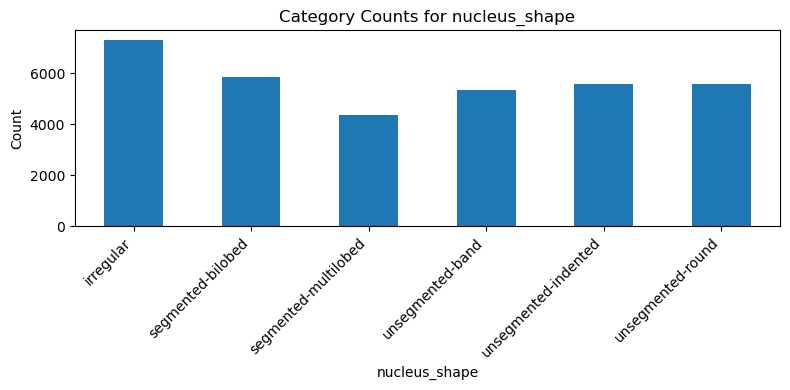

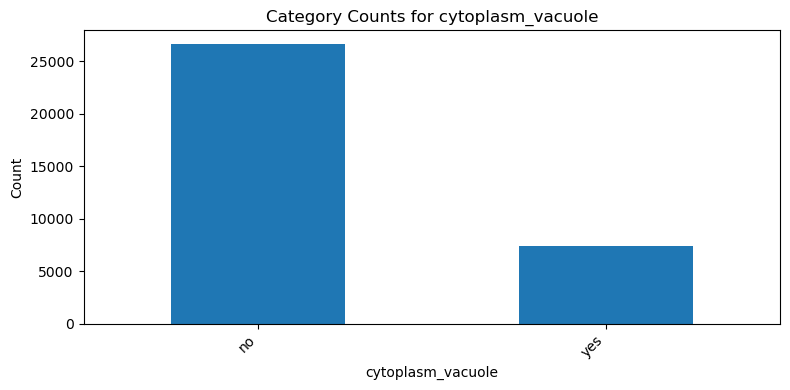

In [58]:
plot_category_counts(train_df)


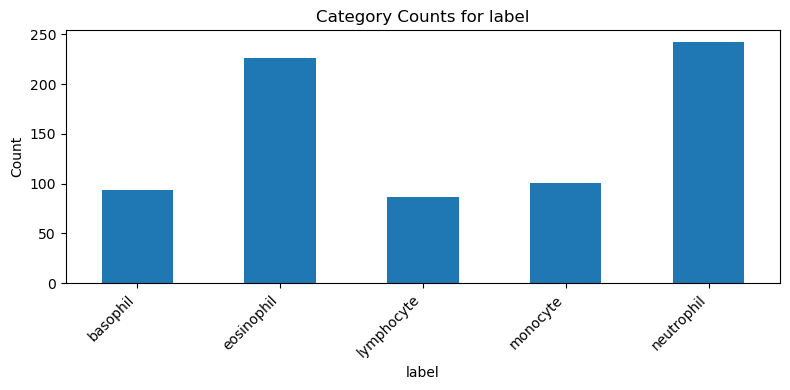

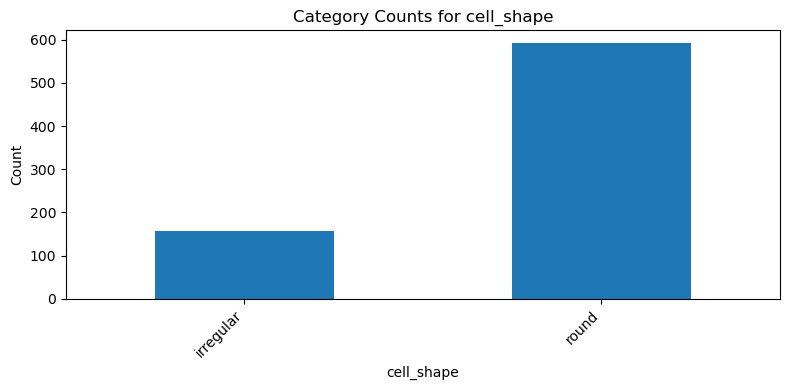

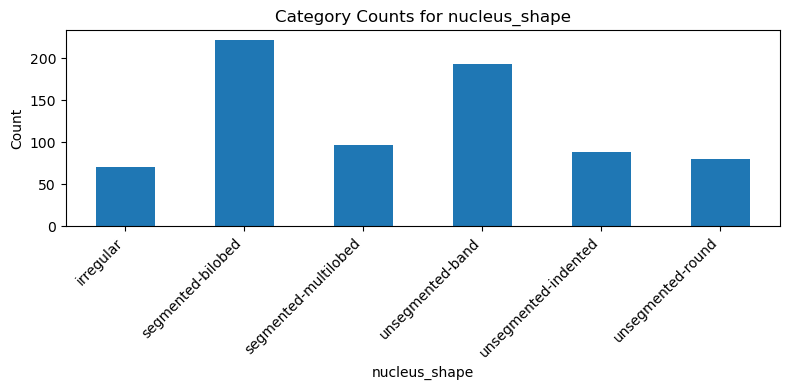

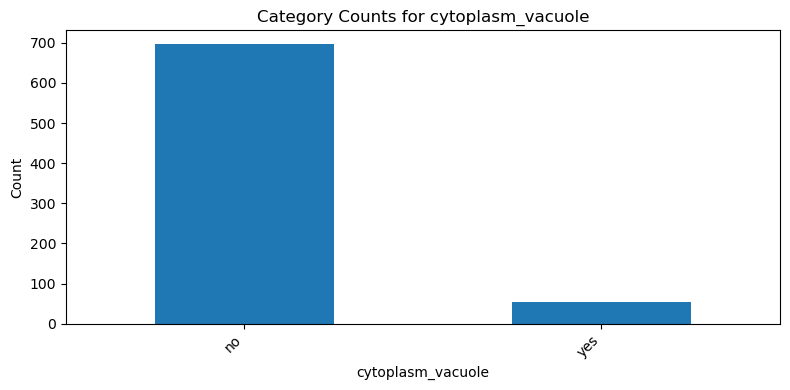

In [59]:
plot_category_counts(val_df)


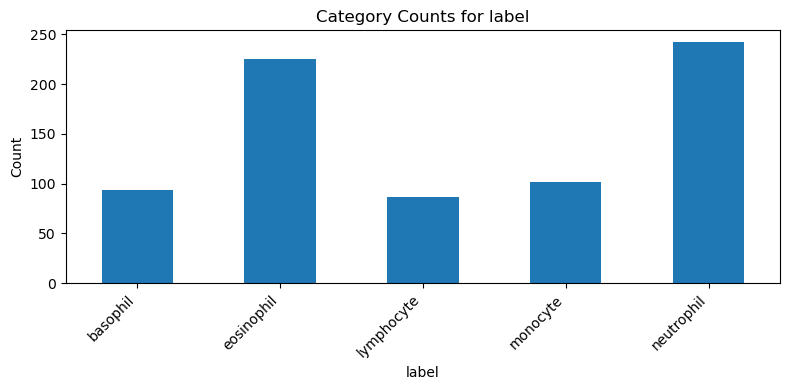

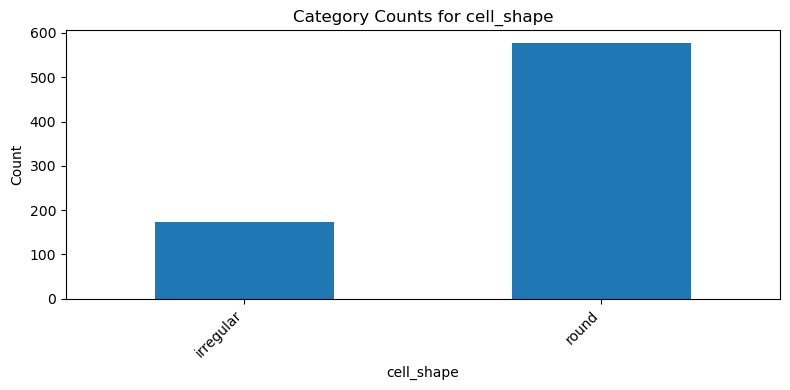

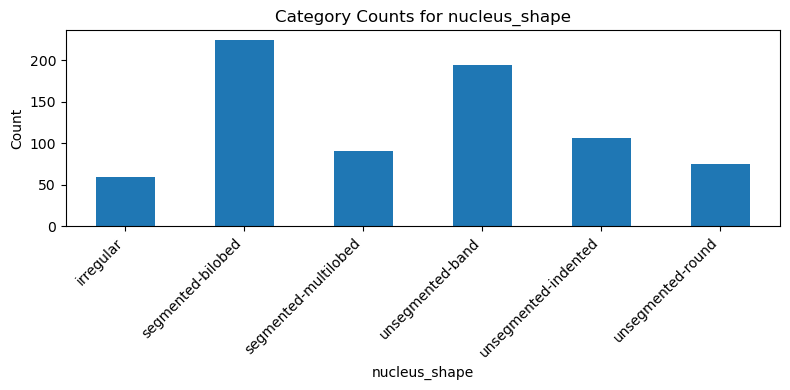

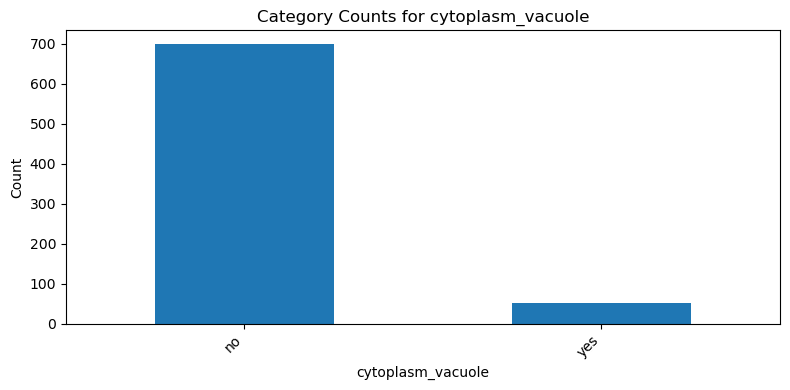

In [60]:
plot_category_counts(test_df)


## Data Augmentation

In [61]:
# !pip uninstall -y  albumentationsx albucore

# # 2) Install *matching* versions from PyPI
# #    (latest stable as of Aug-2025 is 2.0.10)
# !pip install "albumentationsx==2.0.10" --no-cache-dir
# # The line above automatically pulls *albucore 2.0.10*

In [62]:
# pip install opencv-python scikit-image numpy


In [63]:
import cv2
import numpy as np
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform, DualTransform
from skimage.color import rgb2hed, hed2rgb

# ---------- small utils ----------
def _to_uint8(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

def _stack3(gray):
    if gray.ndim == 2:
        return np.repeat(gray[..., None], 3, axis=2)
    return gray

def _bbox_from_mask(m):
    ys, xs = np.where(m > 0)
    if len(xs) == 0:  # empty
        return None
    return max(0, ys.min()), max(0, xs.min()), min(m.shape[0], ys.max()+1), min(m.shape[1], xs.max()+1)

def _safe_paste(dst_img, src_img, dst_mask, src_mask, top, left, alpha_smooth=True):
    """Paste src into dst at (top, left) using src_mask. Optional alpha-smooth edges."""
    h, w = src_mask.shape
    H, W = dst_mask.shape
    # clip paste area
    y0, x0 = max(0, top), max(0, left)
    y1, x1 = min(H, top + h), min(W, left + w)
    sy0, sx0 = y0 - top, x0 - left
    sy1, sx1 = sy0 + (y1 - y0), sx0 + (x1 - x0)

    if y0 >= y1 or x0 >= x1:
        return dst_img, dst_mask

    crop_src_img  = src_img[sy0:sy1, sx0:sx1]
    crop_src_mask = src_mask[sy0:sy1, sx0:sx1].astype(np.float32)
    if alpha_smooth:
        # distance transform to soften edges (0..1)
        dist = cv2.distanceTransform((crop_src_mask>0).astype(np.uint8), cv2.DIST_L2, 3)
        if dist.size > 0:
            dist = dist / (dist.max() + 1e-6)
        # emphasize borders (fade-in)
        alpha = np.clip(dist, 0, 1)[..., None]
    else:
        alpha = (crop_src_mask > 0)[..., None].astype(np.float32)

    # composite
    region = dst_img[y0:y1, x0:x1].astype(np.float32)
    dst_img[y0:y1, x0:x1] = (alpha * crop_src_img.astype(np.float32) +
                             (1 - alpha) * region).astype(np.uint8)
    # update mask
    dst_mask[y0:y1, x0:x1] = np.where(crop_src_mask > 0, 1, dst_mask[y0:y1, x0:x1])
    return dst_img, dst_mask

# ---------- 1) stain robustness ----------
class RandStainHED(ImageOnlyTransform):
    """
    Lightweight H&E 'stain augmentation' in HED space:
    randomly scales/offsets H, E channels and adds mild noise, then converts back to RGB.
    (Not a full RandStainNA normalization, but fast and effective.)
    """
    def __init__(self, h_scale=(0.85, 1.15), e_scale=(0.85, 1.15), d_scale=(0.95, 1.05),
                 h_shift=(-0.1, 0.1), e_shift=(-0.1, 0.1), noise_std=(0.0, 0.02),
                 always_apply=False, p=0.7):
        super().__init__(always_apply, p)
        self.h_scale, self.e_scale, self.d_scale = h_scale, e_scale, d_scale
        self.h_shift, self.e_shift = h_shift, e_shift
        self.noise_std = noise_std

    def apply(self, img, **params):
        img_f = np.clip(img.astype(np.float32)/255.0, 0, 1)
        hed = rgb2hed(img_f)  # float, can be negative
        hs = random.uniform(*self.h_scale); es = random.uniform(*self.e_scale); ds = random.uniform(*self.d_scale)
        hh = random.uniform(*self.h_shift); ee = random.uniform(*self.e_shift)
        ns = random.uniform(*self.noise_std)

        hed[..., 0] = hed[..., 0] * hs + hh
        hed[..., 1] = hed[..., 1] * es + ee
        hed[..., 2] = hed[..., 2] * ds
        if ns > 0:
            hed += np.random.normal(0, ns, hed.shape).astype(np.float32)

        out = hed2rgb(hed)
        out = np.clip(out * 255.0, 0, 255).astype(np.uint8)
        return out

class HEDDeconvolveReturnH(ImageOnlyTransform):
    """Return Hematoxylin channel as 3-channel grayscale (forces nucleus morphology reliance)."""
    def __init__(self, normalize=True, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.normalize = normalize
    def apply(self, img, **params):
        img_f = np.clip(img.astype(np.float32)/255.0, 0, 1)
        hed = rgb2hed(img_f)
        h = hed[..., 0]  # more negative = stronger H; invert & normalize for display
        if self.normalize:
            h = (h - h.min()) / (h.max() - h.min() + 1e-6)
        h = (1.0 - h) * 255.0
        return _stack3(h.astype(np.uint8))

# ---------- 2) instance-aware ops ----------
class InstanceAnisotropicScale(DualTransform):
    """
    Per-nucleus anisotropic scaling around centroid to vary eccentricity.
    Expects instance mask (0 background, 1..N instances).
    """
    def __init__(self, min_s=0.85, max_s=1.15, max_instances=50, always_apply=False, p=0.4):
        super().__init__(always_apply, p)
        self.min_s, self.max_s = min_s, max_s
        self.max_instances = max_instances

    def apply(self, img, **params):
        # image handled in apply_with_params (needs mask)
        return img

    def apply_to_mask(self, mask, **params):
        # mask handled together with image in apply_with_params
        return mask

    def apply_with_params(self, params, img, mask, **kwargs):
        out_img = img.copy()
        out_mask = mask.copy()
        ids = [i for i in np.unique(mask) if i != 0]
        random.shuffle(ids)
        ids = ids[:self.max_instances]

        for i in ids:
            m = (mask == i).astype(np.uint8)
            bbox = _bbox_from_mask(m)
            if bbox is None: 
                continue
            y0, x0, y1, x1 = bbox
            roi_m = m[y0:y1, x0:x1]
            if roi_m.sum() == 0:
                continue

            # crop image region tightly
            roi_img = out_img[y0:y1, x0:x1].copy()

            # centroid
            ys, xs = np.where(roi_m > 0)
            cy, cx = ys.mean(), xs.mean()

            sx = random.uniform(self.min_s, self.max_s)
            sy = random.uniform(self.min_s, self.max_s)

            # scale around centroid: build affine transform
            M = cv2.getRotationMatrix2D((cx, cy), 0, 1.0)  # start identity
            # translate to origin, scale, translate back
            T1 = np.array([[1, 0, -cx],
                           [0, 1, -cy]], dtype=np.float32)
            S  = np.array([[sx, 0, 0],
                           [0, sy, 0]], dtype=np.float32)
            T2 = np.array([[1, 0, cx],
                           [0, 1, cy]], dtype=np.float32)
            A_ = (T2 @ (S @ T1))
            # warp
            h, w = roi_img.shape[:2]
            warped_img = cv2.warpAffine(roi_img, A_, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
            warped_m   = cv2.warpAffine(roi_m*255, A_, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT) > 127

            # clear old region, paste new
            out_img[y0:y1, x0:x1][roi_m.astype(bool)] = 0
            out_mask[y0:y1, x0:x1][roi_m.astype(bool)] = 0
            out_img[y0:y1, x0:x1], tmp_mask = _safe_paste(
                out_img[y0:y1, x0:x1], warped_img, out_mask[y0:y1, x0:x1],
                warped_m.astype(np.uint8), top=0, left=0, alpha_smooth=True
            )
            # restore instance id
            out_mask[y0:y1, x0:x1][tmp_mask>0] = i

        return out_img, out_mask

class InstanceMorphDilateErode(DualTransform):
    """
    Mild per-instance dilation/erosion (±1 iteration) with in-place content warping.
    """
    def __init__(self, max_iter=1, always_apply=False, p=0.2):
        super().__init__(always_apply, p)
        self.max_iter = max_iter

    def apply(self, img, **params): return img
    def apply_to_mask(self, mask, **params): return mask

    def apply_with_params(self, params, img, mask, **kwargs):
        out_img = img.copy()
        out_mask = mask.copy()
        ids = [i for i in np.unique(mask) if i != 0]
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        for i in ids:
            m = (mask == i).astype(np.uint8)
            bbox = _bbox_from_mask(m)
            if bbox is None: continue
            y0, x0, y1, x1 = bbox
            roi_m = m[y0:y1, x0:x1]
            roi_img = out_img[y0:y1, x0:x1].copy()
            iters = random.randint(1, self.max_iter)
            op = random.choice(["dilate", "erode"])
            if op == "dilate":
                new_m = cv2.dilate(roi_m, kernel, iterations=iters)
            else:
                new_m = cv2.erode(roi_m, kernel, iterations=iters)

            # warp image content via simple nearest-neighbor expansion/shrink
            # Create a mask of pixels to fill (new_m - roi_m) or to remove.
            add_region = (new_m > roi_m) & (new_m > 0)
            rem_region = (roi_m > new_m)

            # Fill added ring by pulling boundary colors with distance transform
            if np.any(add_region):
                dist, labels = cv2.distanceTransformWithLabels((roi_m>0).astype(np.uint8),
                                                               cv2.DIST_L2, 3, labelType=cv2.DIST_LABEL_PIXEL)
                # map each added pixel to nearest original nucleus pixel
                ys, xs = np.where(add_region)
                for y, x in zip(ys, xs):
                    lab = labels[y, x]
                    # labels indexes start at 1
                    by, bx = np.argwhere(labels == lab)[0] if lab > 0 else (y, x)
                    roi_img[y, x] = roi_img[by, bx]

            # Remove region: just zero it (will be background)
            roi_img[rem_region] = 0

            # write back
            out_img[y0:y1, x0:x1] = np.where(new_m[..., None].astype(bool), roi_img, out_img[y0:y1, x0:x1])
            out_mask[y0:y1, x0:x1][new_m>0] = i
            out_mask[y0:y1, x0:x1][new_m==0] = np.where(roi_m==0, out_mask[y0:y1, x0:x1][new_m==0], 0)

        return out_img, out_mask

class InstanceContourJitter(DualTransform):
    """
    Small, local affine jitter per nucleus (perturbs shape irregularity without topological breaks).
    """
    def __init__(self, max_px=3, always_apply=False, p=0.4):
        super().__init__(always_apply, p)
        self.max_px = max_px

    def apply(self, img, **params): return img
    def apply_to_mask(self, mask, **params): return mask

    def apply_with_params(self, params, img, mask, **kwargs):
        out_img = img.copy()
        out_mask = mask.copy()
        ids = [i for i in np.unique(mask) if i != 0]
        for i in ids:
            m = (mask == i).astype(np.uint8)
            bbox = _bbox_from_mask(m)
            if bbox is None: continue
            y0, x0, y1, x1 = bbox
            roi_m = m[y0:y1, x0:x1]
            roi_img = out_img[y0:y1, x0:x1].copy()
            if roi_m.sum() == 0: continue

            # pick three boundary points and jitter them slightly to define affine
            cnts, _ = cv2.findContours(roi_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: continue
            cnt = max(cnts, key=cv2.contourArea).reshape(-1,2)
            if len(cnt) < 3: continue
            idxs = np.linspace(0, len(cnt)-1, 3, dtype=int)
            src = cnt[idxs].astype(np.float32)
            jitter = np.random.randint(-self.max_px, self.max_px+1, size=src.shape).astype(np.float32)
            dst = np.clip(src + jitter, [0,0], [roi_m.shape[1]-1, roi_m.shape[0]-1]).astype(np.float32)[:, ::-1]  # swap x/y to (col,row)->(row,col)

            # cv2 expects (x,y) so convert back:
            src_xy = np.stack([src[:,0], src[:,1]], axis=1).astype(np.float32)
            dst_xy = np.stack([dst[:,1], dst[:,0]], axis=1).astype(np.float32)

            A_ = cv2.getAffineTransform(src_xy, dst_xy)
            h, w = roi_img.shape[:2]
            warped_img = cv2.warpAffine(roi_img, A_, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
            warped_m   = cv2.warpAffine(roi_m*255, A_, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT) > 127

            out_img[y0:y1, x0:x1] = np.where(warped_m[..., None], warped_img, out_img[y0:y1, x0:x1])
            out_mask[y0:y1, x0:x1][warped_m] = i
            out_mask[y0:y1, x0:x1][(~warped_m) & (roi_m>0)] = 0
        return out_img, out_mask

class InsMix(DualTransform):
    """
    Copy-smooth-paste a fraction of nuclei to new nearby locations (single image version).
    """
    def __init__(self, copy_ratio=0.3, max_copies=30, smooth_border=True, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.copy_ratio = copy_ratio
        self.max_copies = max_copies
        self.smooth_border = smooth_border

    def apply(self, img, **params): return img
    def apply_to_mask(self, mask, **params): return mask

    def apply_with_params(self, params, img, mask, **kwargs):
        out_img = img.copy()
        out_mask = mask.copy()
        ids = [i for i in np.unique(mask) if i != 0]
        if not ids: 
            return img, mask
        random.shuffle(ids)
        k = max(1, int(len(ids) * self.copy_ratio))
        k = min(k, self.max_copies)
        H, W = mask.shape

        for _ in range(k):
            i = random.choice(ids)
            m = (mask == i).astype(np.uint8)
            bbox = _bbox_from_mask(m)
            if bbox is None: continue
            y0, x0, y1, x1 = bbox
            roi_m = m[y0:y1, x0:x1]
            roi_img = out_img[y0:y1, x0:x1].copy()

            # pick a random background location to paste
            for _try in range(10):
                dy = random.randint(-40, 40)
                dx = random.randint(-40, 40)
                top  = np.clip(y0 + dy, 0, H-1)
                left = np.clip(x0 + dx, 0, W-1)
                if top + roi_m.shape[0] <= H and left + roi_m.shape[1] <= W:
                    # check background at paste site to reduce overlaps
                    patch_bg = out_mask[top:top+roi_m.shape[0], left:left+roi_m.shape[1]]
                    if (patch_bg == 0).mean() > 0.8:
                        out_img, _tmp = _safe_paste(out_img, roi_img, out_mask,
                                                    roi_m, top, left, alpha_smooth=self.smooth_border)
                        break
        return out_img, out_mask

class NucleiMix(InsMix):
    """
    Alias for this single-image example. In multi-image dataloaders, you’d select nuclei
    from under-represented classes and paste between images; here we reuse InsMix behavior.
    """
    def __init__(self, balance_minor_classes=True, **kwargs):
        super().__init__(**kwargs)
        self.balance_minor_classes = balance_minor_classes

# ---------- 3) nucleus-focus regulariser ----------
class OutsideMaskRandomize(DualTransform):
    """
    Replace non-nuclear pixels with blurred + noisy background to reduce context reliance.
    """
    def __init__(self, mode="blur+noise", blur_ks=(9, 15), noise_std=(3, 10),
                 always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.mode = mode
        self.blur_ks = blur_ks
        self.noise_std = noise_std

    def apply(self, img, **params): return img
    def apply_to_mask(self, mask, **params): return mask

    def apply_with_params(self, params, img, mask, **kwargs):
        out = img.copy()
        outside = (mask == 0)
        if self.mode.startswith("blur"):
            k = random.randrange(self.blur_ks[0] | 1, self.blur_ks[1] | 1, 2)  # odd kernel
            blurred = cv2.GaussianBlur(img, (k, k), 0)
            out[outside] = blurred[outside]
        if "noise" in self.mode:
            std = random.uniform(*self.noise_std)
            noise = np.random.normal(0, std, img.shape).astype(np.float32)
            tmp = out.astype(np.float32)
            tmp[outside] = np.clip(tmp[outside] + noise[outside], 0, 255)
            out = tmp.astype(np.uint8)
        return out, mask

# ---------- 4) build the full augmentation ----------
def build_nucleus_augment():
    return A.Compose([
        # stain robustness
        RandStainHED(p=0.7),
        A.OneOf([
            HEDDeconvolveReturnH(p=1.0),  # hematoxylin-only pass
            A.NoOp()
        ], p=0.2),

        # global mild geometry
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=7,
                           border_mode=cv2.BORDER_REFLECT, p=0.7),

        # instance-aware ops
        InsMix(copy_ratio=0.3, smooth_border=True, p=0.5),
        NucleiMix(balance_minor_classes=True, p=0.5),

        # morphology perturbations
        InstanceContourJitter(max_px=3, p=0.4),
        InstanceAnisotropicScale(min_s=0.85, max_s=1.15, p=0.4),
        InstanceMorphDilateErode(max_iter=1, p=0.2),

        # nucleus-focus regularisers
        OutsideMaskRandomize(mode="blur+noise", p=0.5),
        # A.CoarseDropout(max_holes=4, max_height=0.2, max_width=0.2, p=0.2),

        # mild photometric
        A.GaussNoise(var_limit=(5, 15), p=0.2),
        A.RandomBrightnessContrast(0.05, 0.05, p=0.2),
    ], additional_targets={'mask': 'mask'}) 

In [64]:
import albumentations as A
import tensorflow as tf
import numpy as np
BATCH_SIZE = 64
AUGMENT = build_nucleus_augment()
def _albumentations(image_np):
    """NumPy batch → Albumentations → float32 0-1."""
    image_np = (image_np * 255).astype(np.uint8)
    image_np = AUGMENT(image=image_np)["image"]
    return image_np.astype(np.float32) / 255.0

def apply_aug_tf(image):
    image = tf.numpy_function(_albumentations, [image], tf.float32)
    image.set_shape([*IMG_SIZE, 3])     # static shape back
    return image


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/albumentations/core/validation.py:132: UserWarning:

ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.

/tmp/ipykernel_1327/344205007.py:395: UserWarning:

Argument(s) 'var_limit' are not valid for transform GaussNoise



In [65]:
HEADS = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]
SEP = "__"  # your OHE separator (e.g., label__Neutrophil)

def get_ohe_cols(df, head, sep=SEP, class_maps=None):
    # Keep a stable class order (prefer class_maps you used to create OHE)
    if class_maps is not None:
        ordered = [f"{head}{sep}{cls}" for cls in class_maps[head].keys()]
        return ordered
    # fallback: alphabetical
    return sorted([c for c in df.columns if c.startswith(f"{head}{sep}")])

def build_y_ohe_arrays(df, heads=HEADS, class_maps=None):
    y = {}
    class_sizes = {}
    for h in heads:
        cols = get_ohe_cols(df, h, class_maps=class_maps)
        arr = df[cols].to_numpy(dtype="float32")
        y[f"{h}_ohe"] = arr
        class_sizes[h] = arr.shape[1]
    return y, class_sizes


In [66]:
# --- replace your loader factory with this ---
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)

def make_load_one_sample_ohe(class_sizes: dict, *, rescale=False, aug_fn=None):
    """
    aug_fn: a callable(img)->img (e.g., your apply_aug_tf), or None for no augmentation.
    """
    def _fn(sample):
        # image
        img = tf.io.read_file(sample["imageID"])
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0

        # augmentation only if aug_fn is provided
        if aug_fn is not None:
            img = tf.cond(tf.cast(sample["augment"], tf.bool),
                          lambda: aug_fn(img),
                          lambda: img)

        # targets: use your OHE vectors directly
        targets = {
            "label"            : tf.ensure_shape(tf.cast(sample["label_ohe"], tf.float32),            [class_sizes["label"]]),
            "cell_shape"       : tf.ensure_shape(tf.cast(sample["cell_shape_ohe"], tf.float32),       [class_sizes["cell_shape"]]),
            "nucleus_shape"    : tf.ensure_shape(tf.cast(sample["nucleus_shape_ohe"], tf.float32),    [class_sizes["nucleus_shape"]]),
            "cytoplasm_vacuole": tf.ensure_shape(tf.cast(sample["cytoplasm_vacuole_ohe"], tf.float32),[class_sizes["cytoplasm_vacuole"]]),
        }
        return img, targets
    return _fn


In [67]:
def make_dataset_from_df_ohe(
    df, image_root=None, image_col="imageID",
    class_maps=None, batch_size=32, training=True,
    rescale=False, aug_fn=None,   # <-- new
):
    import os, numpy as np, tensorflow as tf

    paths = (df[image_col].apply(lambda x: os.path.join(image_root, str(x))).to_numpy()
             if image_root is not None else df[image_col].astype(str).to_numpy())

    # stack OHE per head (same helper you already have)
    y_ohe, class_sizes = build_y_ohe_arrays(df, heads=["label","cell_shape","nucleus_shape","cytoplasm_vacuole"],
                                            class_maps=class_maps)

    d = {"imageID": paths, "augment": np.full(len(df), bool(training))}
    for h in ["label","cell_shape","nucleus_shape","cytoplasm_vacuole"]:
        d[f"{h}_ohe"] = y_ohe[f"{h}_ohe"]

    ds = tf.data.Dataset.from_tensor_slices(d)
    if training:
        ds = ds.shuffle(len(df), reshuffle_each_iteration=True)

    loader = make_load_one_sample_ohe(class_sizes, rescale=rescale, aug_fn=aug_fn)
    ds = ds.map(loader, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return ds, class_sizes


In [68]:
IMG_EXT = '.jpg'

def fix_path(x):
    x = str(x)                             # just in case it’s an int
    if not x.endswith(IMG_EXT):
        x = x + IMG_EXT                    # add extension if missing
    return os.path.join(IMAGE_DIR, x)

train_df["imageID"] = train_df["imageID"].apply(fix_path)
val_df["imageID"]   = val_df["imageID"].apply(fix_path)

In [69]:
train_df["imageID"][0]

'/home/ec2-user/SageMaker/Asm1/COSC2779-DATA/Hematoxylin/Img_02342.jpg'

In [70]:
train_df['label'].nunique()
train_df['cell_shape'].nunique()
train_df['nucleus_shape'].nunique()

6

In [71]:
# stop

# EfficientNet B5

In [72]:
from itertools import cycle
from math import ceil
import matplotlib.pyplot as plt

TRAIN_COLOR = "#d62728"  # red
VAL_COLOR   = "#ff7f0e"  # orange

def _to_hist_dict(history_or_dict):
    if hasattr(history_or_dict, "history"):  # single History
        return {"run": history_or_dict.history}
    if isinstance(history_or_dict, dict):
        return {k: (v.history if hasattr(v, "history") else v) for k, v in history_or_dict.items()}
    if isinstance(history_or_dict, (list, tuple)):
        return {f"run{i}": (h.history if hasattr(h, "history") else h) for i, h in enumerate(history_or_dict)}
    raise TypeError("Expected History, dict[str,History|dict], or list[History].")

def _loss_keys_in_order(ref_hist: dict, include_overall=True):
    head_losses = sorted([k for k in ref_hist if k.endswith("_loss") and not k.startswith("val_") and k != "loss"])
    return (["loss"] if include_overall and "loss" in ref_hist else []) + head_losses

def plot_history(
    history_hold,
    metric="accuracy",
    ylim=None,
    include_overall=True,
    cols=2,                      # <-- exactly 3 plots per row
    figsize=None,                # if None, auto-size using width_per_panel/height_per_row
    width_per_panel=6.0,
    height_per_row=4.0,
    dpi=150,
    wspace=0.25,
    hspace=0.35,
    legend_fontsize=8,
):
    H = _to_hist_dict(history_hold)
    ref = next(iter(H.values()))
    keys = list(ref.keys())

    # choose train-side keys to plot
    if metric == "loss":
        base_keys = _loss_keys_in_order(ref, include_overall=include_overall)
    elif metric in keys:
        base_keys = [metric if not metric.startswith("val_") else metric[4:]]
    else:
        base_keys = [k for k in keys if not k.startswith("val_") and (k == metric or k.endswith("_" + metric))]
        if not base_keys:
            m = metric[4:] if metric.startswith("val_") else metric
            base_keys = [m]

    n = len(base_keys)
    cols = max(1, int(cols))
    rows = max(1, ceil(n / cols))

    if figsize is None:
        figsize = (width_per_panel * cols, height_per_row * rows)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    # normalize axes to a flat list
    axes = (axes if isinstance(axes, (list, tuple)) else
            (axes.ravel().tolist() if hasattr(axes, "ravel") else [axes]))
    # ensure we have enough axes slots
    if len(axes) < n:
        raise RuntimeError("Internal error: not enough axes created")

    for i, base in enumerate(base_keys):
        ax = axes[i]
        markers = cycle([None, "o", "s", "d", "^", "v", "x"])  # vary by run
        for name, hist in H.items():
            mkr = next(markers)
            y_tr = hist.get(base, None)
            y_va = hist.get(f"val_{base}", None)

            if y_tr is not None:
                ax.plot(y_tr, label=f"{name}:{base}", color=TRAIN_COLOR, linewidth=2,
                        marker=mkr, markevery=max(1, len(y_tr)//10), alpha=0.9)
            if y_va is not None:
                ax.plot(y_va, label=f"{name}:val_{base}", color=VAL_COLOR,
                        linewidth=2, linestyle="--", alpha=0.9)

            if (y_tr is None) and (y_va is not None):
                ax.text(0.02, 0.95, "train series missing", transform=ax.transAxes,
                        ha="left", va="top", fontsize=9, color="gray")

        ax.set_title(base)
        ax.set_xlabel("epoch")
        if ylim is not None: ax.set_ylim(*ylim)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=legend_fontsize)

    # hide any leftover empty axes
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.tight_layout()
    plt.show()


In [73]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model, regularizers
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications.efficientnet import preprocess_input as efnet_preprocess


# def build_efficientnetb5_multitask(
#     input_shape=(456, 456, 3),
#     num_classes: dict = None,
#     unfreeze_pct: float = 0.3,
#     dropout: float = 0.4,
#     l2_weight: float = 1e-5,
# ) -> tf.keras.Model:
#     """
#     Create a multi-task classifier on EfficientNet-B5.

#     Args:
#         input_shape: recommended (456,456,3) for B5.
#         num_classes: dict like {'label':5, 'cell_shape':2, 'nucleus_shape':6, 'cytoplasm_vacuole':2}
#         unfreeze_pct: fraction of backbone layers to unfreeze (fine-tune).
#         dropout: dropout after pooling.
#         l2_weight: L2 weight for the penultimate dense layer (optional).

#     Returns:
#         Keras Model with one shared backbone and multiple softmax heads.
#     """
#     assert num_classes is not None and isinstance(num_classes, dict) and len(num_classes) > 0

#     # ----- Backbone -----
#     base = EfficientNetB5(
#         include_top=False,
#         weights="imagenet",
#         input_shape=input_shape,
#         drop_connect_rate=0.2,  # default-ish for B5
#     )

#     # Freeze early layers, unfreeze the last `unfreeze_pct`
#     n_layers = len(base.layers)
#     n_unfreeze = max(1, int(n_layers * unfreeze_pct))
#     for l in base.layers[:-n_unfreeze]:
#         l.trainable = False
#     # Keep BatchNorm layers trainable to avoid BN statistics drift
#     for l in base.layers[-n_unfreeze:]:
#         if isinstance(l, layers.BatchNormalization):
#             l.trainable = True
#         else:
#             l.trainable = True

#     # ----- Head trunk -----
#     inp = base.input
#     x = layers.Lambda(efnet_preprocess, name="preprocess")(inp)  # optional but recommended
#     x = base(x, training=False)  # use inference mode for backbone while frozen
#     x = layers.GlobalAveragePooling2D(name="gap")(x)
#     x = layers.BatchNormalization(name="bn_head")(x)
#     x = layers.Dense(
#         512, activation="relu",
#         kernel_regularizer=regularizers.l2(l2_weight),
#         name="penultimate"
#     )(x)
#     x = layers.Dropout(dropout, name="dropout")(x)

#     # ----- Task heads -----
#     outs = []
#     for name, n in num_classes.items():
#         outs.append(layers.Dense(n, activation="softmax", name=name)(x))

#     return Model(inp, outs, name="EfficientNetB5_multitask")


In [74]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import EfficientNetB0  # change to ResNet/DenseNet if you prefer
# EPOCHS = 10
# model = build_efficientnetb5_multitask(
#     input_shape=(224,224,3),
#     num_classes=NUM_CLASSES,
#     unfreeze_pct=0.3,   # tune this (e.g., 0.2–0.4)
#     dropout=0.4,
#     l2_weight=1e-5,
# )
# losses  = {k: "categorical_crossentropy" for k in NUM_CLASSES}
# metrics = {k: ["accuracy"] for k in NUM_CLASSES}
# loss_wts = {'label': 2.0, 'nucleus_shape': 2.0, 'cell_shape': 1.0, 'cytoplasm_vacuole': 1.0}

# model.compile(
#     optimizer=tf.keras.optimizers.AdamW(1e-4),
#     loss=losses,
#     loss_weights=loss_wts,
#     metrics=metrics,jit_compile=True)

In [75]:
# # check once, right in the notebook
# print("label one-hot depth :", train_ds.element_spec[1]["label"].shape[-1])
# print("model output units :", model.get_layer("label").output_shape[-1])

# # nucleus head
# print("nucleus one-hot depth:", train_ds.element_spec[1]["nucleus_shape"].shape[-1])
# print("model output units  :", model.get_layer("nucleus_shape").output_shape[-1])


In [76]:
# # one element after ALL dataset transformations
# for img, tgt in train_ds.take(1):
#     print(type(tgt))
#     break


In [77]:
# spec = train_ds.element_spec
# print("Element spec:\n", spec)           # should show a dict with 4 tensors

# # quick one-batch probe
# for imgs, tgt in train_ds.take(1):
#     print("Type:", type(tgt))
#     if isinstance(tgt, dict):
#         for k, v in tgt.items():
#             print(k, v.shape, tf.reduce_sum(v,1)[:3])  # row sums must be 1
#     break


In [78]:
# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
#     tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(
#         "best_multihead_wbc.h5", monitor="val_label_accuracy",
#         save_best_only=True, save_weights_only=False)
# ]

# # 4️⃣  Train!
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=callbacks
# )

## Train with mixup dataset

In [79]:
# model_mixup = build_efficientnetb5_multitask(
#     input_shape=(224,224,3),
#     num_classes=NUM_CLASSES,
#     unfreeze_pct=0.3,   # tune this (e.g., 0.2–0.4)
#     dropout=0.4,
#     l2_weight=1e-5,
# )
# losses  = {k: "categorical_crossentropy" for k in NUM_CLASSES}
# metrics = {k: ["accuracy"] for k in NUM_CLASSES}
# loss_wts = {'label': 2.0, 'nucleus_shape': 2.0, 'cell_shape': 1.0, 'cytoplasm_vacuole': 1.0}

# model_mixup.compile(
#     optimizer=tf.keras.optimizers.AdamW(1e-4),
#     loss=losses,
#     loss_weights=loss_wts,
#     metrics=metrics)

In [80]:
# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
#     tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(
#         "best_multihead_wbc.h5", monitor="val_label_accuracy",
#         save_best_only=True, save_weights_only=False)
# ]

# # 4️⃣  Train!
# history_mixup = model_mixup.fit(
#     train_ds_mix,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=callbacks
# )

In [81]:
# import numpy as np
# import tensorflow as tf

# def _ohe_cols(df, head, sep="__"):
#     return [c for c in df.columns if c.startswith(f"{head}{sep}")]

# def _head_indices_from_df(df, head, sep="__"):
#     """Return (indices array, class names) for a head using original col or OHE."""
#     if head in df.columns:
#         # Map class -> index using value_counts order (stable sorted for reproducibility)
#         classes = sorted(df[head].dropna().unique().tolist())
#         cmap = {c:i for i,c in enumerate(classes)}
#         return df[head].map(cmap).to_numpy().astype("int32"), classes
#     ohe = _ohe_cols(df, head, sep)
#     if not ohe:
#         raise ValueError(f"No source for head '{head}' (neither '{head}' col nor OHE '{head}{sep}*').")
#     classes = [c.split(sep, 1)[1] for c in ohe]
#     return df[ohe].to_numpy().argmax(axis=1).astype("int32"), classes

# def _dict_from_df(df_slice, image_root, image_col, y_ohe):
#     if image_root is None:
#         paths = df_slice[image_col].astype(str).to_numpy()
#     else:
#         paths = df_slice[image_col].apply(lambda x: os.path.join(image_root, str(x))).to_numpy()
#     d = {"imageID": paths, "augment": np.ones(len(df_slice), bool), "aug_prob": np.ones(len(df_slice), np.float32)}
#     for h in ["label","cell_shape","nucleus_shape","cytoplasm_vacuole"]:
#         d[f"{h}_ohe"] = y_ohe[f"{h}_ohe"][df_slice.index.to_numpy()]
#     return d

# def make_balanced_dataset_from_df_ohe(
#     df,
#     balance_on: str,                    # e.g. "nucleus_shape"
#     image_root=None,
#     image_col="imageID",
#     class_maps=None,
#     batch_size=32,
#     aug_fn=None,                        # e.g. apply_aug_tf
#     rescale=False,
#     minority_aug_prob=1.0,              # optional: heavier aug for minority
#     majority_aug_prob=0.2,              # optional: light aug for majority
#     seed=42,
# ):
#     """
#     Build a dataset that samples uniformly over classes of `balance_on` at each step.
#     """
#     import os

#     # Build OHE arrays and class sizes (you already have this util)
#     y_ohe, class_sizes = build_y_ohe_arrays(
#         df, heads=["label","cell_shape","nucleus_shape","cytoplasm_vacuole"],
#         class_maps=class_maps
#     )

#     # Class index per row for the head we balance on
#     idx, class_names = _head_indices_from_df(df, balance_on)

#     # Make per-class sub-datasets
#     K = len(class_names)
#     per_class_datasets = []
#     for k in range(K):
#         rows = df.index[idx == k]
#         if len(rows) == 0:
#             # skip empty class (rare but possible)
#             continue
#         df_k = df.loc[rows]

#         # optional: per-class augmentation probability (heavier on minority)
#         count_k = len(df_k)
#         max_count = max(np.bincount(idx))    # majority size
#         p_aug = minority_aug_prob if count_k < max_count else majority_aug_prob

#         # build per-class dict
#         d = _dict_from_df(df_k, image_root, image_col, y_ohe)
#         d["aug_prob"] = np.full(len(df_k), p_aug, np.float32)

#         ds_k = tf.data.Dataset.from_tensor_slices(d).shuffle(len(df_k), seed=seed, reshuffle_each_iteration=True).repeat()
#         per_class_datasets.append(ds_k)

#     # Merge them with uniform sampling across classes
#     weights = [1.0/len(per_class_datasets)] * len(per_class_datasets)
#     merged = tf.data.Dataset.sample_from_datasets(per_class_datasets, weights=weights, seed=seed)

#     # Map → (image, targets)
#     loader = make_load_one_sample_ohe(class_sizes, rescale=rescale, aug_fn=aug_fn)
#     ds = merged.map(loader, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return ds, class_sizes, class_names


In [82]:

# train_ds_balanced_nucleus, CLASS_SIZES, CLASS_NAMES = make_balanced_dataset_from_df_ohe(
#     train_df,
#     balance_on="nucleus_shape",     # the most imbalanced head
#     image_root=None,
#     class_maps=class_maps,
#     batch_size=BATCH_SIZE,
#     aug_fn=apply_aug_tf,
#     minority_aug_prob=1.0,
#     majority_aug_prob=0.2,
# )


In [83]:
# train_ds_mix_balanced_nucleus = (
#     train_ds_balanced_nucleus                             # already batched (32, …)
#     .map(lambda x, y: mixup_fn(x, y),       # 👈 pass two args, no tuple unpack
#          num_parallel_calls=tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

# # validation remains unchanged


In [84]:
# show_batch(train_ds_mix_balanced_nucleus)

In [85]:
# model_mixup_balanced_nucleus = build_efficientnetb5_multitask(
#     input_shape=(224,224,3),
#     num_classes=NUM_CLASSES,
#     unfreeze_pct=0.3,   # tune this (e.g., 0.2–0.4)
#     dropout=0.4,
#     l2_weight=1e-5,
# )
# losses  = {k: "categorical_crossentropy" for k in NUM_CLASSES}
# metrics = {k: ["accuracy"] for k in NUM_CLASSES}
# loss_wts = {'label': 2.0, 'nucleus_shape': 2.0, 'cell_shape': 1.0, 'cytoplasm_vacuole': 1.0}

# model_mixup_balanced_nucleus.compile(
#     optimizer=tf.keras.optimizers.AdamW(1e-4),
#     loss=losses,
#     loss_weights=loss_wts,
#     metrics=metrics)

In [86]:
# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
#     tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(
#         "best_multihead_wbc.h5", monitor="val_label_accuracy",
#         save_best_only=True, save_weights_only=False)
# ]

# # 4️⃣  Train!
# # counts for the head you balanced on (e.g., nucleus_shape)
# idx = train_df["nucleus_shape"].map(class_maps["nucleus_shape"]).to_numpy()
# counts = np.bincount(idx, minlength=len(class_maps["nucleus_shape"]))
# images_per_epoch = counts.max() * len(counts)           # target per epoch
# steps_per_epoch  = int(np.ceil(images_per_epoch / 32))

# history_mixup_balanced_nucleus = model_mixup_balanced_nucleus.fit(
#     train_ds_mix_balanced_nucleus,
#     epochs=EPOCHS,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_ds,
#     callbacks=callbacks
# )


In [87]:
# plot_history(history_mixup_balanced_nucleus)     # overall loss + label_loss + cell_shape_loss + nucleus_shape_loss + cytoplasm_vacuole_loss

In [88]:
# plot_history(history_mixup_balanced_nucleus, metric="loss")     # overall loss + label_loss + cell_shape_loss + nucleus_shape_loss + cytoplasm_vacuole_loss

## Concactinate logi

In [89]:
import os, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input as efnet_preprocess


In [90]:
HEADS   = ["label", "cell_shape", "nucleus_shape", "cytoplasm_vacuole"]
OHE_SEP = "__"
# IMG_DIR = IMG         # <- change if needed
IMG_EXTS = [".jpg",".jpeg",".png"]
IMG_SIZE = (224,224)
BATCH    = 64
EPOCHS   = 10
LR       = 3e-5

In [91]:
import os
import numpy as np
import pandas as pd

# 1) Remove any accidental "code" columns that slipped into the DF
def _strip_noise_cols(df: pd.DataFrame) -> pd.DataFrame:
    bad = [c for c in df.columns if c.startswith("#") or "=====" in c]
    if bad:
        print("Dropping noisy columns:", bad)
        df = df.drop(columns=bad)
    return df

train_df = _strip_noise_cols(train_df)
val_df   = _strip_noise_cols(val_df)

# 2) Keep only rows where the absolute path exists
def _keep_existing_paths(df: pd.DataFrame, path_col="imageID") -> pd.DataFrame:
    df = df.copy()
    df[path_col] = df[path_col].astype(str).str.strip()
    ok_mask = df[path_col].apply(os.path.exists)
    missing = df.loc[~ok_mask, path_col].tolist()
    if missing:
        print(f"Dropping {len(missing)} missing files. Example:", missing[:3])
    return df.loc[ok_mask].reset_index(drop=True)

train_df = _keep_existing_paths(train_df, "imageID")
val_df   = _keep_existing_paths(val_df, "imageID")

# 3) Rebuild targets from OHE or raw columns (uses your earlier helpers)
HEADS = ["label","cell_shape","nucleus_shape","cytoplasm_vacuole"]
OHE_SEP = "__"

def _ohe_cols(df, head, sep="__"):
    return [c for c in df.columns if c.startswith(f"{head}{sep}")]

def fit_vocabs_from_train(train_df: pd.DataFrame, heads=HEADS, sep="__"):
    vocabs, sizes = {}, []
    for h in heads:
        ohe = _ohe_cols(train_df, h, sep)
        if ohe:
            classes = [c.split(sep,1)[1] for c in ohe]     # keep OHE column order
        else:
            classes = sorted(train_df[h].dropna().unique().tolist())
        vocabs[h] = classes
        sizes.append(len(classes))
    cuts = np.cumsum(sizes)[:-1]
    return vocabs, sizes, cuts

VOCABS, SIZES, CUTS = fit_vocabs_from_train(train_df, HEADS, OHE_SEP)

def encode_with_vocabs(df: pd.DataFrame, vocabs: dict, heads=HEADS, sep="__"):
    ys = []
    for h in heads:
        ohe = _ohe_cols(df, h, sep)
        if ohe:
            ys.append(df[ohe].to_numpy().argmax(axis=1).astype("int32"))
        else:
            cmap = {c:i for i,c in enumerate(vocabs[h])}
            ys.append(df[h].map(cmap).astype("int32").to_numpy())
    return np.stack(ys, axis=1).astype("int32")

y_tr = encode_with_vocabs(train_df, VOCABS, HEADS, OHE_SEP)
y_va = encode_with_vocabs(val_df,   VOCABS, HEADS, OHE_SEP)

# 4) Use the absolute paths directly
paths_tr = train_df["imageID"].astype(str).tolist()
paths_va = val_df["imageID"].astype(str).tolist()

print("train paths:", len(paths_tr), "labels:", y_tr.shape)
print("val paths:", len(paths_va), "labels:", y_va.shape)


train paths: 34068 labels: (34068, 4)
val paths: 750 labels: (750, 4)


In [92]:
def _albumentations_255(img_uint8: np.ndarray) -> np.ndarray:
    """
    Albumentations expects uint8 [0,255]. Keep it that way so the model-side
    efnet_preprocess can do the canonical normalization.
    """
    # img_uint8 is HxWx3 uint8
    out = AUGMENT(image=img_uint8)["image"]          # still uint8
    return out.astype(np.float32)                    # back to float32 [0..255]

def apply_aug_tf_255(img_255: tf.Tensor) -> tf.Tensor:
    """
    tf.Tensor (float32 [0..255]) -> Albumentations (uint8) -> float32 [0..255].
    """
    img = tf.cast(tf.clip_by_value(img_255, 0.0, 255.0), tf.float32)
    img = tf.numpy_function(
        func=lambda x: _albumentations_255(x.astype(np.uint8)),
        inp=[img],
        Tout=tf.float32
    )
    img.set_shape([*IMG_SIZE, 3])  # restore static shape for graph
    return img


In [93]:
AUTO = tf.data.AUTOTUNE
# IMG_SIZE = (224,224)

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # keep [0,255]; model does efnet_preprocess
    return img

def map_train(path, yrow):
    img = load_image(path)
    # (optional) tf.image augs OR your Albumentations wrapper
    img = apply_aug_tf_255(img) 
    return img, yrow

def map_val(path, yrow):
    img = load_image(path)
    return img, yrow

def make_ds(paths, y, training=True, batch=16):
    ds = tf.data.Dataset.from_tensor_slices((paths, y))
    if training:
        ds = ds.shuffle(len(paths))
        ds = ds.map(map_train, num_parallel_calls=AUTO)
    else:
        ds = ds.map(map_val, num_parallel_calls=AUTO)
    return ds.batch(batch).prefetch(AUTO)

train_ds = make_ds(paths_tr, y_tr, training=True, batch=BATCH)
val_ds   = make_ds(paths_va, y_va, training=False, batch=BATCH)


2025-09-02 13:24:14.148136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 13:24:14.149366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 13:24:14.150367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_batch_safe(dataset, n=4):
    """
    Display up to n images and their multitask labels from a dataset / generator.
    Handles float32 [0,255], float32 [0,1], and uint8 automatically.
    """
    # --- fetch first batch -------------------------------------------------
    if isinstance(dataset, tf.data.Dataset):
        images, targets = next(iter(dataset))
    else:  # Keras Sequence
        images, targets = dataset[0]

    images = images.numpy() if isinstance(images, tf.Tensor) else images

    def _prep_img(img):
        """Make image safe for imshow."""
        if img.dtype == np.uint8:
            return img  # already fine
        if img.dtype == np.float32 or img.dtype == np.float64:
            if img.max() > 1.0:  # [0,255] float
                return img.astype(np.uint8)
            else:  # [0,1] float
                return img
        return img

    def decode_one(sample_idx):
        if isinstance(targets, dict):
            txt = []
            for k, v in targets.items():
                label = np.argmax(v[sample_idx]) if v.ndim > 1 else v[sample_idx]
                txt.append(f"{k}:{label}")
            return "\n".join(txt)
        else:
            return f"label:{np.argmax(targets[sample_idx])}"

    # --- plot --------------------------------------------------------------
    n = min(n, images.shape[0])
    plt.figure(figsize=(4 * n, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(_prep_img(images[i]))
        plt.title(decode_one(i))
        plt.axis("off")
    plt.tight_layout()
    plt.show()


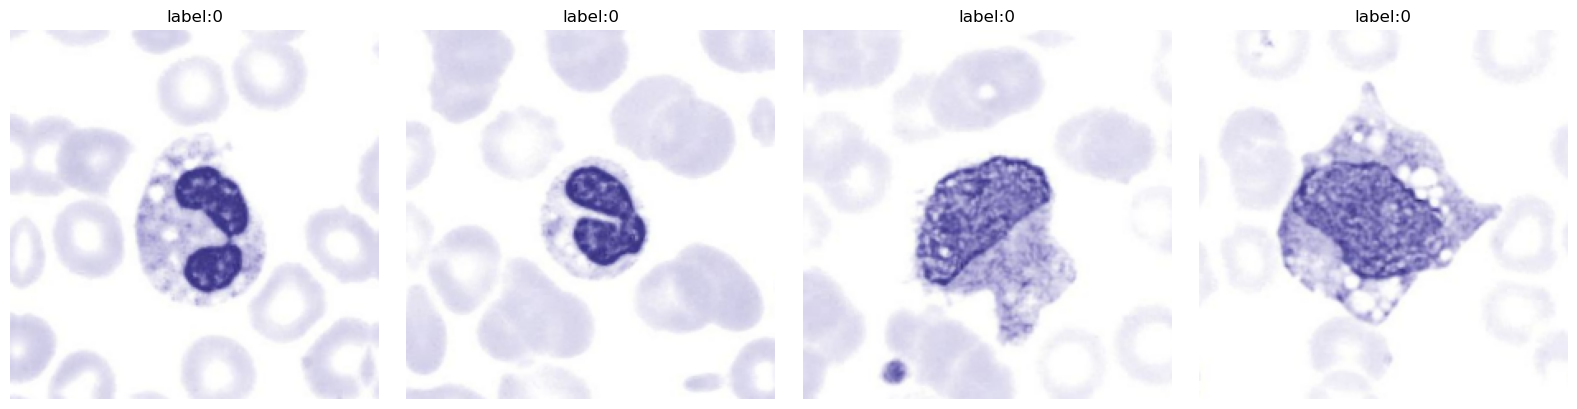

In [95]:
show_batch_safe(train_ds)

In [96]:

# ---------- Variant A: image-only MixUp (labels unchanged, integers) ----------
def mixup_images_only(imgs, y_int, alpha=0.2):
    bs  = tf.shape(imgs)[0]
    idx = tf.random.shuffle(tf.range(bs))

    g1  = tf.random.gamma([], alpha, dtype=tf.float32)
    g2  = tf.random.gamma([], alpha, dtype=tf.float32)
    lam = g1 / (g1 + g2)                           # scalar λ

    imgs_mix = lam * imgs + (1. - lam) * tf.gather(imgs, idx)
    # keep y_int unchanged so your sparse block loss still works
    return imgs_mix, y_int

# ---------- Variant B: proper MixUp (soft labels for block-softmax) ----------
def _one_hot_heads(y_int, sizes):
    # y_int: [B,H], sizes: list[int] of len H
    return [tf.one_hot(y_int[:, i], depth=C, dtype=tf.float32) for i, C in enumerate(sizes)]

def mixup_block_with_soft_labels(imgs, y_int, sizes, alpha=0.2):
    bs  = tf.shape(imgs)[0]
    idx = tf.random.shuffle(tf.range(bs))

    # per-sample lambdas (better than one scalar for the whole batch)
    g1  = tf.random.gamma([bs], alpha, dtype=tf.float32)
    g2  = tf.random.gamma([bs], alpha, dtype=tf.float32)
    lam = g1 / (g1 + g2)                            # [B]

    imgs2 = tf.gather(imgs, idx)
    y2    = tf.gather(y_int, idx)

    lam_img = tf.reshape(lam, [-1, 1, 1, 1])        # for images
    lam_lbl = tf.reshape(lam, [-1, 1])              # for labels

    y_heads  = _one_hot_heads(y_int, sizes)
    y2_heads = _one_hot_heads(y2,    sizes)
    y_mix_heads = [lam_lbl * a + (1. - lam_lbl) * b for a, b in zip(y_heads, y2_heads)]

    imgs_mix = lam_img * imgs + (1. - lam_img) * imgs2
    y_mix    = tf.concat(y_mix_heads, axis=-1)      # [B, sum(sizes)]
    return imgs_mix, y_mix

In [97]:
train_ds_mix = (
    train_ds
    .map(lambda x, y: mixup_block_with_soft_labels(x, y, sizes=SIZES, alpha=0.4),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


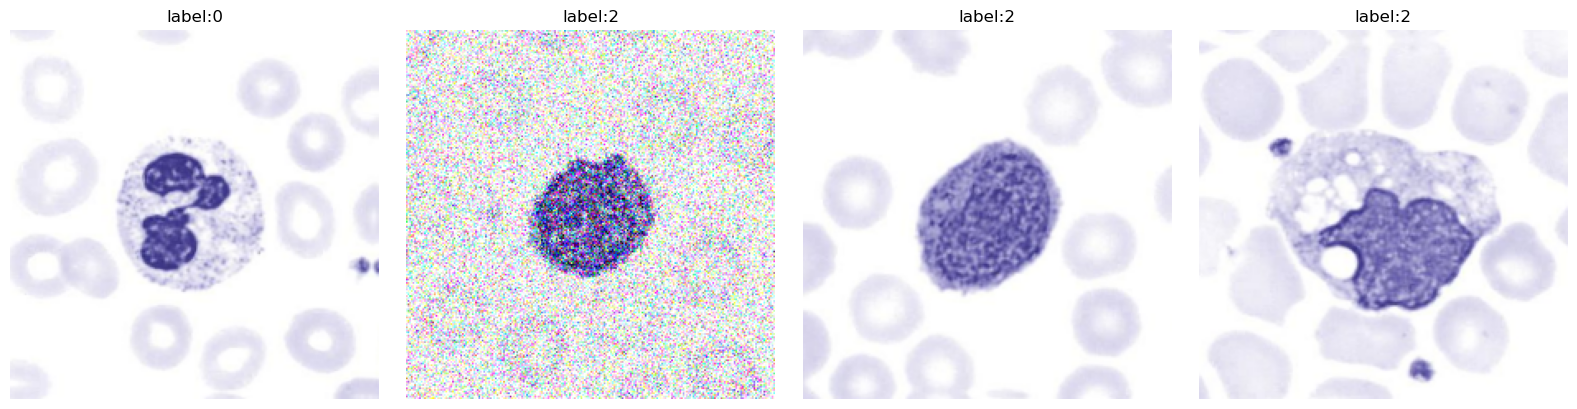

In [98]:
show_batch_safe(train_ds)

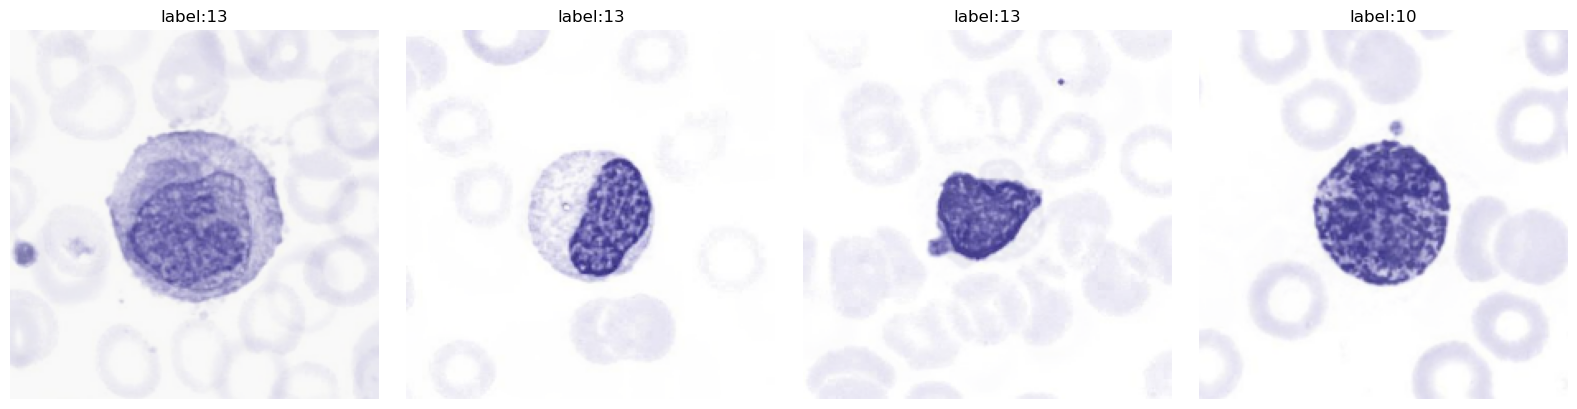

In [99]:
show_batch_safe(train_ds_mix)

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input as efnet_preprocess

def make_block_softmax_loss(sizes, average=True):
    sizes = list(sizes)
    sce = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'   # we reduce manually
    )
    def loss(y_true, logits):
        # y_true: (B, H) int; logits: (B, sum(sizes))
        splits = tf.split(logits, sizes, axis=-1)
        per_head_means = []
        for i, logit_i in enumerate(splits):
            y_i = tf.cast(y_true[:, i], tf.int32)      # ensure integer dtype
            li = sce(y_i, logit_i)                     # (B,)
            per_head_means.append(tf.reduce_mean(li))  # scalar
        total = tf.add_n(per_head_means)
        return total / float(len(sizes)) if average else total
    return loss

def make_head_acc(i, sizes, name):
    sizes = list(sizes)
    def metric(y_true, logits):
        split_i = tf.split(logits, sizes, axis=-1)[i]
        probs_i = tf.nn.softmax(split_i, axis=-1)
        y_i = tf.cast(y_true[:, i], tf.int32)
        return tf.keras.metrics.sparse_categorical_accuracy(y_i, probs_i)
    metric.__name__ = name
    return metric


In [101]:

def build_efficientnetb5_blocksoftmax(
    input_shape=(*IMG_SIZE,3),
    sizes=None,
    unfreeze_pct=0.3,
    dropout=0.4,
    l2_weight=1e-5,
):
    assert sizes and len(sizes) > 0
    total = int(sum(sizes))

    inp = layers.Input(shape=input_shape)
    x = layers.Lambda(efnet_preprocess)(inp)
    base = EfficientNetB5(include_top=False, input_tensor=x, weights="imagenet", pooling="avg")

    # partial fine-tune
    n = len(base.layers)
    cut = max(1, int(n * (1 - unfreeze_pct)))
    for idx, lyr in enumerate(base.layers):
        lyr.trainable = (idx >= cut)

    x = base.output
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="swish", kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.Dropout(dropout)(x)
    logits = layers.Dense(total, activation=None, name="block_logits")(x)   # ONE output layer

    return Model(inp, logits, name="EffNetB5_blocksoftmax_onehead")


In [102]:
model = build_efficientnetb5_blocksoftmax(sizes=SIZES)
loss_fn = make_block_softmax_loss(SIZES)
metrics = [make_head_acc(i, SIZES, name=f"{h}_acc") for i, h in enumerate(HEADS)]
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss_fn, metrics=metrics)

In [103]:
cbs = [
    tf.keras.callbacks.ModelCheckpoint("best_blocksoftmax.keras", monitor="val_loss",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs, verbose=1)


Epoch 1/10


2025-09-02 13:25:21.481448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEffNetB5_blocksoftmax_onehead/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-02 13:25:24.689891: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-09-02 13:25:26.435596: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2df34bf520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-02 13:25:26.435628: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-02 13:25:26.442239: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756819526.527994    1744 device_compiler.h:186] Compiled cluster

533/533 [==============================] - ETA: 0s - loss: 0.6251 - label_acc: 0.7972 - cell_shape_acc: 0.8334 - nucleus_shape_acc: 0.5503 - cytoplasm_vacuole_acc: 0.8500
Epoch 1: val_loss improved from inf to 0.43504, saving model to best_blocksoftmax.keras
533/533 [==============================] - 395s 602ms/step - loss: 0.6251 - label_acc: 0.7972 - cell_shape_acc: 0.8334 - nucleus_shape_acc: 0.5503 - cytoplasm_vacuole_acc: 0.8500 - val_loss: 0.4350 - val_label_acc: 0.9267 - val_cell_shape_acc: 0.8907 - val_nucleus_shape_acc: 0.5733 - val_cytoplasm_vacuole_acc: 0.9520 - lr: 3.0000e-05
Epoch 2/10
533/533 [==============================] - ETA: 0s - loss: 0.2822 - label_acc: 0.9403 - cell_shape_acc: 0.9205 - nucleus_shape_acc: 0.7696 - cytoplasm_vacuole_acc: 0.9435
Epoch 2: val_loss improved from 0.43504 to 0.39580, saving model to best_blocksoftmax.keras
533/533 [==============================] - 299s 560ms/step - loss: 0.2822 - label_acc: 0.9403 - cell_shape_acc: 0.9205 - nucleus_sh

/tmp/ipykernel_1327/1755529341.py:88: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



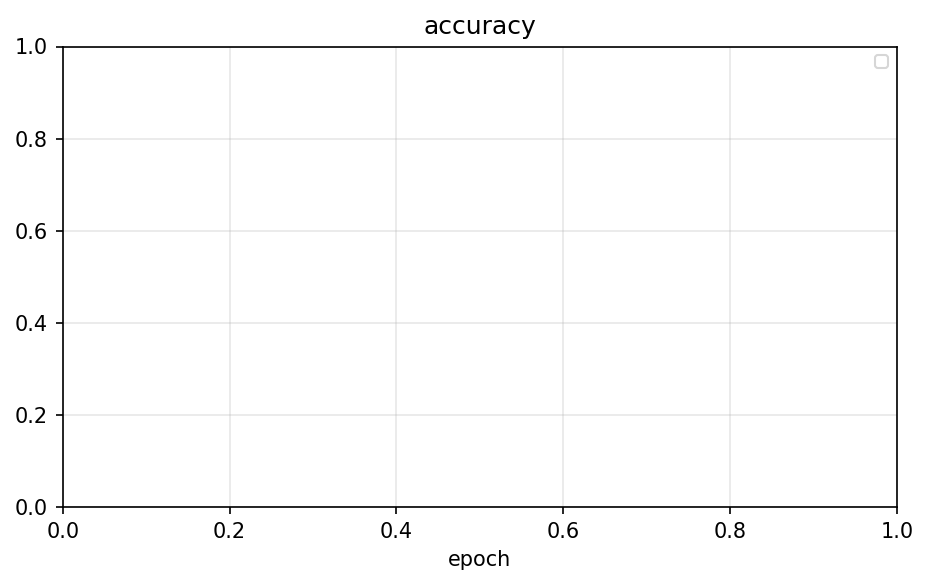

In [108]:
plot_history(history)  # overall loss + label_loss + cell_shape_loss + nucleus_shape_loss + cytoplasm_vacuole_loss

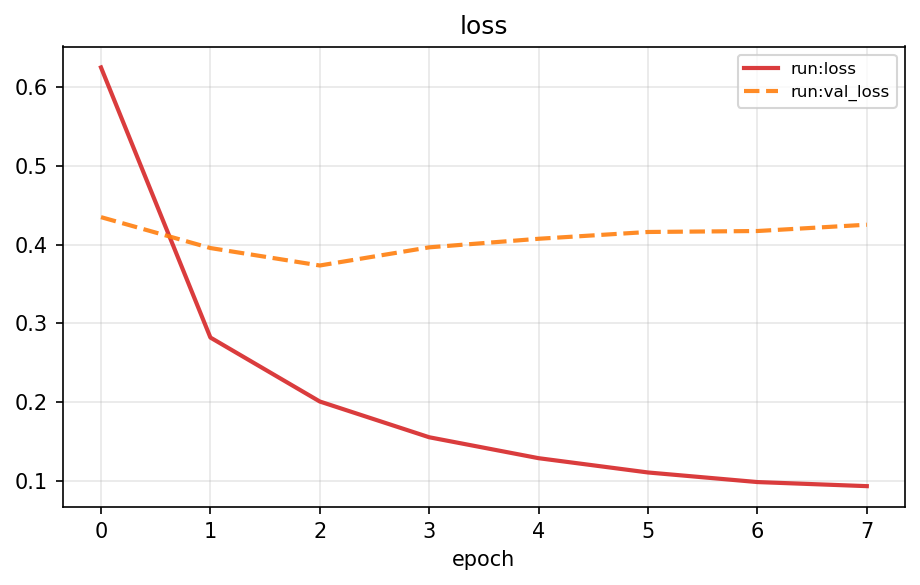

In [109]:
plot_history(history, metric = 'loss')     # overall loss + label_loss + cell_shape_loss + nucleus_shape_loss + cytoplasm_vacuole_loss

## Parameter Tunning

In [110]:
! pip install optuna

##  Model Analysis 
